# P5 : Catégoriser automatiquement des questions
# Analyse Exploratoire
## 1. Importation des données
### 1.1. Chargement des librairies

In [1]:
# Manipulation des données
import numpy as np
import pandas as pd

# Visualisation des données
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import pyLDAvis
import pyLDAvis.sklearn
from IPython.display import HTML

sns.set_style("whitegrid")

# Parsing des données texte
from bs4 import BeautifulSoup

# Librairie nltk pour traiter les mots
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# Stockage de données
from collections import Counter, defaultdict

# Vectorisation des mots
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Outils de sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline

# Réduction de dimension
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation, NMF, PCA, TruncatedSVD

# Modèles
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier

# Data Persistence
import pickle
import joblib

# Utilisation du module nb_black pour formater le code
%load_ext nb_black

<IPython.core.display.Javascript object>

### 1.2. Chargement des données
On importe le fichier créé lors de la phase d'analyse exploratoire.

In [10]:
data = pd.read_csv("./data/df_filt.csv")
data.head()

Id                                              Title  \
0  68775869  Support for password authentication was remove...   
1  55921442  How to fix "ReferenceError: primordials is not...   
2  63607158  Xcode 12, building for iOS Simulator, but link...   
3  57456188  Why is the result of ('b'+'a'+ + 'a' + 'a').to...   
4  62653114  How to deal with this git warning? "Pulling wi...   

                                                Body  \
0  <p>I got this error on my console when I tried...   
1  <p>I have installed Node.js modules by 'npm in...   
2  <p>I am trying to get a large (and working on ...   
3  <p>I was practicing some JavaScript when one o...   
4  <p>After a <code>git pull origin master</code>...   

                                                Tags         CreationDate  \
0         <git><github><token><github-api><git-pull>  2021-08-13 16:49:34   
1                   <node.js><sass><gulp><gulp-sass>  2019-04-30 12:57:10   
2  <ios><xcode><xcode12><xcode12beta5><xcode12beta6>  2020-08-26 23:40:26   
3                      <javascript><type-conversion>  2019-08-12 05:50:43   
4                                              <git>  2020-06-30 08:18:57   

   Score  ViewCount  AnswerCount  CommentCount  FavoriteCount  \
0    830     589566           36            16            278   
1    741     740973           40             2            172   
2    624     357368           47             8            185   
3    623      97124            8             7            106   
4    598     230395            9             4            110   

   CreationDateDelta  ViewCountPerDay  
0                140      4210.884937  
1                976       759.185869  
2                491       727.822244  
3                872       111.379457  
4                549       419.655380

<IPython.core.display.Javascript object>

On va ne garder que les colonnes suivantes :
- Title
- Body 
- Tags

In [11]:
df = data[["Title", "Body", "Tags"]]
df.shape

(47032, 3)

<IPython.core.display.Javascript object>

## 2. Pré-traitements des données textes bruts
On va créer différentes fonctions pour effectuer les étapes suivantes :
- supprimer balises html
- récupérer que les mots avec des lettres
- mettre les mots en minuscule 
- enlever les stop words de langue anglaise
- ne garder que les noms communs
- normaliser les données (lemmatisation ou stemmatisation)

### 2.1. Suppression des balises HTML

In [12]:
def off_html(raw_text):

    """ Fonction pour supprimer les balises html d'un texte
        
    - Arguments :
        - raw_text : texte brut où il faut supprimer les balises (string)
    
    - Retourne :
        - text : le texte sans balise (string)
    """

    # Parsage du texte et supprimer balises html
    text = BeautifulSoup(raw_text, "html.parser").get_text()

    return text

<IPython.core.display.Javascript object>

In [13]:
%%time
# Liste vide pour stocker le texte
text_off_html = []

# Pour chaque ligne du dataframe
for i in range(0, data.shape[0]):

    # fusion des titre et body pour chaque ligne
    raw_text = data.Title.iloc[i] + " " + data.Body.iloc[i]

    # Ajout de chaque texte sans balise
    text_off_html.append(off_html(raw_text))

# Affichage du premier élément = 1 string de texte
text_off_html[0]

CPU times: user 36.5 s, sys: 120 ms, total: 36.6 s
Wall time: 36.7 s


'Support for password authentication was removed. Please use a personal access token instead I got this error on my console when I tried to use git pull:\n\nremote: Support for password authentication was removed on August 13, 2021. Please use a personal access token instead.\nremote: Please see https://github.blog/2020-12-15-token-authentication-requirements-for-git-operations/ for more information.\nfatal: unable to access "..." : The requested URL returned error: 403\n\nIt\'s very weird, because I just follow the documentation and created a token two weeks ago on GitHub that expires on Tue, Oct 26, 2021. Why has this been removed today?\n'

<IPython.core.display.Javascript object>

In [14]:
len(text_off_html[0].split(" "))

91

<IPython.core.display.Javascript object>

### 2.2. Récupération de la liste des mots
On va filtrer en ne gardant que les termes d'au moins 3 lettres, ce qui permet d'éliminer des mots couramment utilisés en programmation (comme les variables représentées par une seule lettre), mais malheureusement cela supprime aussi des langages de programmation (C, R...). Par ailleurs, nous filtrons les termes génériques à l'aide stopwords de langue anglaise. Ce filtrage est perfectible car les textes ici appartiennent à un domaine particulier et on pourrait filtrer des termes utiles. La mise en place d'un dictionnaire de stopwords pertinents serait idéale mais pour des raisons de timing, cela n'a pas été fait ici.

In [15]:
def get_words(text):

    """ Fonction pour récupérer pour chaque ligne du dataframe
    la liste des mots en effectuant les traitements suivants :
        - suppression des termes autres que des lettres
        - texte mis en minuscule
        - suppression des mots de 2 lettres et moins
        - suppression des English stopwords
        
    - Arguments :
        - text : liste de textes à traiter  
    
    - Retourne :
        - tokens_cleaned : la liste des mots
    """

    # Tokenizer pour récupérer que les termes avec des lettres
    tokenizer = nltk.RegexpTokenizer(r"[a-zA-Z]+")

    # Récupération de la liste des mots mis en minuscule
    tokens = tokenizer.tokenize(text.lower())

    # On ne garde que les mots d'au moins 3 lettres
    tokens = list(filter(lambda x: len(x) >= 3, tokens))

    # Récupération des stopwords English
    sw = set(stopwords.words("english"))

    # Supprimer les stop words
    tokens_cleaned = [token for token in tokens if not token in sw]

    return tokens_cleaned

<IPython.core.display.Javascript object>

In [16]:
%%time
# Liste des textes cleanés
text_cleaned = [get_words(token) for token in text_off_html]

# Affichage du premier élément
# =liste des mots de la première ligne
text_cleaned[0]

CPU times: user 13.2 s, sys: 1.19 s, total: 14.3 s
Wall time: 14.4 s


['support',
 'password',
 'authentication',
 'removed',
 'please',
 'use',
 'personal',
 'access',
 'token',
 'instead',
 'got',
 'error',
 'console',
 'tried',
 'use',
 'git',
 'pull',
 'remote',
 'support',
 'password',
 'authentication',
 'removed',
 'august',
 'please',
 'use',
 'personal',
 'access',
 'token',
 'instead',
 'remote',
 'please',
 'see',
 'https',
 'github',
 'blog',
 'token',
 'authentication',
 'requirements',
 'git',
 'operations',
 'information',
 'fatal',
 'unable',
 'access',
 'requested',
 'url',
 'returned',
 'error',
 'weird',
 'follow',
 'documentation',
 'created',
 'token',
 'two',
 'weeks',
 'ago',
 'github',
 'expires',
 'tue',
 'oct',
 'removed',
 'today']

<IPython.core.display.Javascript object>

In [17]:
len(text_cleaned[0])

62

<IPython.core.display.Javascript object>

In [18]:
%%time
# Liste des textes cleanés
tags_cleaned = [get_words(token) for token in data["Tags"].tolist()]

# Affichage du premier élément
# = liste des tags de la première ligne
tags_cleaned[0]

CPU times: user 6.67 s, sys: 892 ms, total: 7.56 s
Wall time: 7.57 s


['git', 'github', 'token', 'github', 'api', 'git', 'pull']

<IPython.core.display.Javascript object>

### 2.3. Filtrage sur les noms communs
Les process et technologies utilisés sont en général identifiés sous forme de nom. On va utiliser la technique de POS Tagging (Parts of Speech Tagging) dont le principe est d’identifier le type d'un mot d'une partie d'un texte basé sur sa définition et le contexte. Le POS utilisé ici n'est pas spécifique aux textes en relation avec l'informatique, donc il se peut que certains termes soient supprimés car non considérés comme des noms communs.

In [19]:
def get_nouns(tokens):

    """ Fonction pour récupérer les noms communs
        
    - Arguments :
        - tokens : liste des mots à traiter  
    
    - Retourne :
        - token_list : liste des mots de type nom commun
    """

    # POS tagging
    pos_t = nltk.pos_tag(tokens)

    # Récupération des noms communs
    token_list = [token[0] for token in pos_t if token[1] in ("NN", "NNS")]

    return token_list

<IPython.core.display.Javascript object>

In [20]:
%%time
# Liste des textes avec seulement les noms
noun_text = [get_nouns(tokens) for tokens in text_cleaned]

# Affichage du premier élément
# = liste des mots de la première ligne
noun_text[0]

CPU times: user 7min 25s, sys: 1.67 s, total: 7min 27s
Wall time: 7min 27s


['support',
 'password',
 'authentication',
 'please',
 'use',
 'access',
 'console',
 'use',
 'pull',
 'support',
 'password',
 'authentication',
 'please',
 'use',
 'access',
 'please',
 'github',
 'authentication',
 'requirements',
 'operations',
 'information',
 'fatal',
 'access',
 'weird',
 'documentation',
 'weeks',
 'oct',
 'today']

<IPython.core.display.Javascript object>

On observe quand même la présence de mots qui ne sont pas des noms (please).

In [21]:
len(noun_text[0])

28

<IPython.core.display.Javascript object>

### 2.4. Normalisation des mots
On va normaliser les mots pour éviter les forme multiples.

On a au choix 2 techniques :
- Stemming (racinisation) : conserve la racine du mot en supprimant les préfixes et suffixes. Cette méthode est plus rapide, par contre des mots peuvent avoir la même racine mais être différents d'un point de vue sémantique.
- Lemmatisation : représente les mots sous leur forme canonique, on obtient ainsi des lemmes (nom au singulier, verbe à l'infinitif...). On va ainsi obtenir plus de mots proches d'un point de vue "racine" mais pas forcément d'un point de vue sémantique.

La limite de NLTK est que certains termes au pluriel vont être mis au singulier, ce qui va modifier le nom de certaines technologies ("ios" écrit sous forme "io" ou "keras" en "kera").

In [22]:
def get_stems(tokens):

    """ Fonction pour récupérer les stems (=racines, en supprimant
    préfixes, suffixes) des mots d'une liste
        
    - Arguments :
        - tokens : liste des mots à traiter  
    
    - Retourne :
        - stemmed_tokens : liste des stems
    """

    # Initialisation du stemmer
    stemmer = PorterStemmer()

    # Récupération des stems
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    return stemmed_tokens

<IPython.core.display.Javascript object>

In [23]:
def get_lems(tokens):

    """ Fonction pour récupérer les lems (=forme canonique, nom au singulier,
    verbe à l'infinitif...) des mots d'une liste
        
    - Arguments :
        - tokens : liste des mots à traiter  
    
    - Retourne :
        - lemmatized_tokens : liste des lems
    """

    # Initialisation du lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Récupération des lems
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return lemmatized_tokens

<IPython.core.display.Javascript object>

In [24]:
%%time
# Liste des textes sous forme de stems
stem_text = [get_stems(tokens) for tokens in noun_text]

# Affichage du premier élément
# = liste des stems de la première ligne
stem_text[0]

CPU times: user 1min 32s, sys: 348 ms, total: 1min 32s
Wall time: 1min 32s


['support',
 'password',
 'authent',
 'pleas',
 'use',
 'access',
 'consol',
 'use',
 'pull',
 'support',
 'password',
 'authent',
 'pleas',
 'use',
 'access',
 'pleas',
 'github',
 'authent',
 'requir',
 'oper',
 'inform',
 'fatal',
 'access',
 'weird',
 'document',
 'week',
 'oct',
 'today']

<IPython.core.display.Javascript object>

In [25]:
len(stem_text[0])

28

<IPython.core.display.Javascript object>

In [26]:
%%time
# Liste des textes sous forme de lems
lem_text = [get_lems(tokens) for tokens in noun_text]

# Affichage du premier élément
# = liste des lems de la première ligne
lem_text[0]

CPU times: user 19.6 s, sys: 158 ms, total: 19.8 s
Wall time: 19.9 s


['support',
 'password',
 'authentication',
 'please',
 'use',
 'access',
 'console',
 'use',
 'pull',
 'support',
 'password',
 'authentication',
 'please',
 'use',
 'access',
 'please',
 'github',
 'authentication',
 'requirement',
 'operation',
 'information',
 'fatal',
 'access',
 'weird',
 'documentation',
 'week',
 'oct',
 'today']

<IPython.core.display.Javascript object>

Paradoxalement, la lemmatisation a été plus rapide que le stemming. Cela est peut être du au fait qu'il y a eu le filtrage par nom commun précédemment.

In [27]:
len(lem_text[0])

28

<IPython.core.display.Javascript object>

In [28]:
%%time
# Liste des tags sous forme de stems
stem_tag = [get_stems(tokens) for tokens in tags_cleaned]

# Affichage du premier élément
# = liste des tags stemmisés de la première ligne
stem_tag[0]

CPU times: user 4.43 s, sys: 17.4 ms, total: 4.45 s
Wall time: 4.45 s


['git', 'github', 'token', 'github', 'api', 'git', 'pull']

<IPython.core.display.Javascript object>

In [29]:
%%time
# Liste des tags sous forme de lems
lem_tag = [get_lems(tokens) for tokens in tags_cleaned]

# Affichage du premier élément
# = liste liste des tags lemmisés de la première ligne
lem_tag[0]

CPU times: user 814 ms, sys: 5.36 ms, total: 819 ms
Wall time: 820 ms


['git', 'github', 'token', 'github', 'api', 'git', 'pull']

<IPython.core.display.Javascript object>

On met dans un même dataframe les textes et tags sous forme de stems et de lems, ainsi que leur longueur.

In [30]:
# Texte original sans balise html
df_text_tag = pd.DataFrame(text_off_html, columns=["raw_text"])

# Longueur de ce texte
df_text_tag["len_text"] = (
    df_text_tag["raw_text"].apply(lambda x: x.split(" ")).apply(lambda x: len(x))
)

# Tags originaux
df_text_tag["raw_tags"] = data.Tags

# Liste des stems
df_text_tag["stemmed_text"] = stem_text

# Liste des lems
df_text_tag["lemmed_text"] = lem_text

# Longueur du texte préprocessé
df_text_tag["len_preprocessed_text"] = df_text_tag["lemmed_text"].apply(
    lambda x: len(x)
)

# Liste des tags stems
df_text_tag["stemmed_tags"] = stem_tag

# Liste des tags lems
df_text_tag["lemmed_tags"] = lem_tag

# Longueur des tags préprocessés
df_text_tag["len_preprocessed_tags"] = df_text_tag["lemmed_tags"].apply(
    lambda x: len(x)
)

# Affichage du dataframe
df_text_tag

raw_text  len_text  \
0      Support for password authentication was remove...        91   
1      How to fix "ReferenceError: primordials is not...        95   
2      Xcode 12, building for iOS Simulator, but link...       181   
3      Why is the result of ('b'+'a'+ + 'a' + 'a').to...        40   
4      How to deal with this git warning? "Pulling wi...       175   
...                                                  ...       ...   
47027  The ComposeView adapter does not work in a var...        46   
47028  How do I undo a merge , after I merged a branc...        90   
47029  ReactJS - You may need an appropriate loader t...        98   
47030  CSS, use @supports to detect @font-face suppor...       101   
47031  Field 'last_login' expected a number but got d...       617   

                                                raw_tags  \
0             <git><github><token><github-api><git-pull>   
1                       <node.js><sass><gulp><gulp-sass>   
2      <ios><xcode><xcode12><xcode12beta5><xcode12beta6>   
3                          <javascript><type-conversion>   
4                                                  <git>   
...                                                  ...   
47027                 <android><android-jetpack-compose>   
47028  <version-control><git-merge><atlassian-sourcet...   
47029                                          <reactjs>   
47030    <css><conditional-statements><font-face><check>   
47031                                           <django>   

                                            stemmed_text  \
0      [support, password, authent, pleas, use, acces...   
1      [referenceerror, primordi, node, modul, gulp, ...   
2      [xcode, io, simul, file, architectur, arm, xco...   
3      [result, tolowercas, banana, javascript, javas...   
4      [deal, git, diverg, branch, pull, origin, mast...   
...                                                  ...   
47027  [composeview, adapt, work, variant, problem, c...   
47028  [merg, branch, master, branch, guy, branch, ma...   
47029  [reactj, loader, handl, file, type, error, use...   
47030  [css, use, support, face, support, use, suppor...   
47031  [field, login, number, face, problem, django, ...   

                                             lemmed_text  \
0      [support, password, authentication, please, us...   
1      [referenceerror, primordials, node, module, gu...   
2      [xcode, io, simulator, file, architecture, arm...   
3      [result, tolowercase, banana, javascript, java...   
4      [deal, git, divergent, branch, pull, origin, m...   
...                                                  ...   
47027  [composeview, adapter, work, variant, problem,...   
47028  [merge, branch, master, branch, guy, branch, m...   
47029  [reactjs, loader, handle, file, type, error, u...   
47030  [cs, use, support, face, support, use, support...   
47031  [field, login, number, face, probleme, django,...   

       len_preprocessed_text  \
0                         28   
1                         22   
2                         50   
3                         12   
4                         50   
...                      ...   
47027                     14   
47028                     22   
47029                     21   
47030                     37   
47031                    186   

                                            stemmed_tags  \
0           [git, github, token, github, api, git, pull]   
1                         [node, sass, gulp, gulp, sass]   
2           [io, xcode, xcode, xcode, beta, xcode, beta]   
3                            [javascript, type, convers]   
4                                                  [git]   
...                                                  ...   
47027                [android, android, jetpack, compos]   
47028  [version, control, git, merg, atlassian, sourc...   
47029                                           [reactj]   
47030        [css, condit, statement, font, face, check]   

<IPython.core.display.Javascript object>

On va regarder s'il y a des lignes vides, c'est-à-dire avec des listes vides.

In [31]:
df_text_tag.loc[df_text_tag["len_preprocessed_text"] == 0]

Empty DataFrame
Columns: [raw_text, len_text, raw_tags, stemmed_text, lemmed_text, len_preprocessed_text, stemmed_tags, lemmed_tags, len_preprocessed_tags]
Index: []

<IPython.core.display.Javascript object>

In [32]:
df_text_tag.loc[df_text_tag["len_preprocessed_tags"] == 0]

raw_text  len_text  \
66     Do I need to explicitly handle negative number...       614   
254    What is the difference between using and await...        62   
476    'static' value appears to reset after function...       171   
477    What is a niebloid? With C++20 we can read the...        59   
512    Inline version of a function returns different...       122   
...                                                  ...       ...   
46773  Why am I getting a message segmentation fault?...       120   
46778  Null Reference Exception in Recursive Function...       468   
46784  How do I combine two sets of 2 columns in a da...       214   
46815  How to define the destructor to safely free a ...       457   
46847  How to unite touching polygons with equal numb...       412   

           raw_tags                                       stemmed_text  \
66              <c>  [need, number, digit, class, problem, number, ...   
254    <c#><c#-8.0>  [differ, use, case, studio, var, someth, var, ...   
476            <c#>  [valu, function, call, lot, articl, static, st...   
477    <c++><c++20>  [term, cpprefer, today, articl, post, post, cu...   
512           <c++>  [version, function, return, valu, non, version...   
...             ...                                                ...   
46773     <c><cs50>  [messag, segment, fault, function, convert, wo...   
46778          <f#>  [refer, except, function, code, chapter, http,...   
46784           <r>  [set, datafram, column, gather, function, exam...   
46815         <c++>  [defin, destructor, array, instanc, code, poin...   
46847       <r><sf>  [polygon, number, user, point, number, polygon...   

                                             lemmed_text  \
66     [need, number, digit, class, problem, number, ...   
254    [difference, use, case, studio, var, something...   
476    [value, function, call, lot, article, static, ...   
477    [term, cppreference, today, article, post, pos...   
512    [version, function, return, value, non, versio...   
...                                                  ...   
46773  [message, segmentation, fault, function, conve...   
46778  [reference, exception, function, code, chapter...   
46784  [set, dataframe, column, gather, function, exa...   
46815  [define, destructor, array, instance, code, po...   
46847  [polygon, number, user, point, number, polygon...   

       len_preprocessed_text stemmed_tags lemmed_tags  len_preprocessed_tags  
66                        69           []          []                      0  
254                       10           []          []                      0  
476                       36           []          []                      0  
477                       13           []          []                      0  
512                       46           []          []                      0  
...                      ...          ...         ...                    ...  
46773                     35           []          []                      0  
46778                    100           []          []                      0  
46784                     41           []          []                      0  
46815                     70           []          []                      0  
46847                    125           []          []                      0  

[226 rows x 9 columns]

<IPython.core.display.Javascript object>

Il y a des lignes avec tags vides, on va donc les supprimer.

In [33]:
df_text_tag_1 = df_text_tag.loc[df_text_tag["len_preprocessed_tags"] > 0]
df_text_tag_1 = df_text_tag_1.reset_index(drop=True)
df_text_tag_1

raw_text  len_text  \
0      Support for password authentication was remove...        91   
1      How to fix "ReferenceError: primordials is not...        95   
2      Xcode 12, building for iOS Simulator, but link...       181   
3      Why is the result of ('b'+'a'+ + 'a' + 'a').to...        40   
4      How to deal with this git warning? "Pulling wi...       175   
...                                                  ...       ...   
46801  The ComposeView adapter does not work in a var...        46   
46802  How do I undo a merge , after I merged a branc...        90   
46803  ReactJS - You may need an appropriate loader t...        98   
46804  CSS, use @supports to detect @font-face suppor...       101   
46805  Field 'last_login' expected a number but got d...       617   

                                                raw_tags  \
0             <git><github><token><github-api><git-pull>   
1                       <node.js><sass><gulp><gulp-sass>   
2      <ios><xcode><xcode12><xcode12beta5><xcode12beta6>   
3                          <javascript><type-conversion>   
4                                                  <git>   
...                                                  ...   
46801                 <android><android-jetpack-compose>   
46802  <version-control><git-merge><atlassian-sourcet...   
46803                                          <reactjs>   
46804    <css><conditional-statements><font-face><check>   
46805                                           <django>   

                                            stemmed_text  \
0      [support, password, authent, pleas, use, acces...   
1      [referenceerror, primordi, node, modul, gulp, ...   
2      [xcode, io, simul, file, architectur, arm, xco...   
3      [result, tolowercas, banana, javascript, javas...   
4      [deal, git, diverg, branch, pull, origin, mast...   
...                                                  ...   
46801  [composeview, adapt, work, variant, problem, c...   
46802  [merg, branch, master, branch, guy, branch, ma...   
46803  [reactj, loader, handl, file, type, error, use...   
46804  [css, use, support, face, support, use, suppor...   
46805  [field, login, number, face, problem, django, ...   

                                             lemmed_text  \
0      [support, password, authentication, please, us...   
1      [referenceerror, primordials, node, module, gu...   
2      [xcode, io, simulator, file, architecture, arm...   
3      [result, tolowercase, banana, javascript, java...   
4      [deal, git, divergent, branch, pull, origin, m...   
...                                                  ...   
46801  [composeview, adapter, work, variant, problem,...   
46802  [merge, branch, master, branch, guy, branch, m...   
46803  [reactjs, loader, handle, file, type, error, u...   
46804  [cs, use, support, face, support, use, support...   
46805  [field, login, number, face, probleme, django,...   

       len_preprocessed_text  \
0                         28   
1                         22   
2                         50   
3                         12   
4                         50   
...                      ...   
46801                     14   
46802                     22   
46803                     21   
46804                     37   
46805                    186   

                                            stemmed_tags  \
0           [git, github, token, github, api, git, pull]   
1                         [node, sass, gulp, gulp, sass]   
2           [io, xcode, xcode, xcode, beta, xcode, beta]   
3                            [javascript, type, convers]   
4                                                  [git]   
...                                                  ...   
46801                [android, android, jetpack, compos]   
46802  [version, control, git, merg, atlassian, sourc...   
46803                                           [reactj]   
46804        [css, condit, statement, font, face, check]   

<IPython.core.display.Javascript object>

On a perdu 226 lignes soit 0.5% des données.

### 2.5. Fréquence de distribution des mots

In [3]:
def distrib_freq(corpus):

    """ Fonction pour récupérer la fréquence des mots dans un corpus
    
    - Arguments :
        - corpus : liste des textes contenant les mots dont il faut
        déterminer la fréquence
    
    - Retourne :
        - df_freq_words : dataframe contenant la fréquence des mots
        classée par ordre décroissant
    """

    # Liste de tous les mots
    words = [token for token_list in corpus for token in token_list]

    # Dictionnaire qui renvoit l'occurence de tous les termes
    words_occur = Counter(words)

    # Récupération par ordre de fréquence
    words_mostcommon = words_occur.most_common()

    # On met la distribution dans un dataframe
    df_freq_words = pd.DataFrame(
        words_mostcommon, columns=["word", "frequency"]
    ).set_index("word")

    # Tri par fréquence
    df_freq_words.sort_values("frequency", ascending=False, inplace=True)

    return df_freq_words

<IPython.core.display.Javascript object>

In [35]:
# Fréquence des stems
stem_freq = distrib_freq(df_text_tag_1.stemmed_text)

# 50 Stems les plus fréquents
stem_freq.head(50)

frequency
word               
error         49045
file          46246
java          43261
name          36902
data          34626
class         34321
import        32361
com           30733
version       30318
code          29523
valu          27491
modul         26683
http          26089
app           24851
user          24417
function      23384
packag        22529
return        22398
type          21638
test          20684
use           19771
imag          19062
org           18984
line          18364
python        17880
project       17062
core          16704
servic        15797
log           15725
applic        14671
const         14576
json          14171
time          14110
path          14071
request       13689
model         13649
compon        13567
messag        13371
server        12850
exampl        12730
option        12676
android       12591
client        12409
list          12140
div           12124
view          12122
problem       12111
node          12047
way           11862
method        11849

<IPython.core.display.Javascript object>

In [36]:
# Nombre de stems différents
stem_freq.shape[0]

145357

<IPython.core.display.Javascript object>

In [37]:
# Fréquence des lems
lem_freq = distrib_freq(df_text_tag_1.lemmed_text)

# 50 lems les plus fréquents
lem_freq.head(50)

frequency
word                  
error            49043
file             46226
java             43261
name             36891
data             34626
class            34318
import           32106
com              30733
version          30308
code             29498
value            27491
module           26676
http             26089
user             24417
app              23857
function         22650
return           22396
package          22241
type             21491
test             20573
use              19121
image            19053
org              18977
line             18363
python           17879
project          16843
core             16704
service          15796
log              15422
application      14651
const            14570
json             14149
path             14070
time             14022
request          13666
model            13629
component        13562
message          13317
server           12849
example          12729
option           12645
android          12591
client           12388
view             12120
problem          12109
div              12079
node             12047
list             12032
way              11862
method           11844

<IPython.core.display.Javascript object>

In [38]:
# Nombre de lems différents
lem_freq.shape[0]

152849

<IPython.core.display.Javascript object>

Sans surprises, il y a plus de lems que de stems.

On va comparer leur distribution.

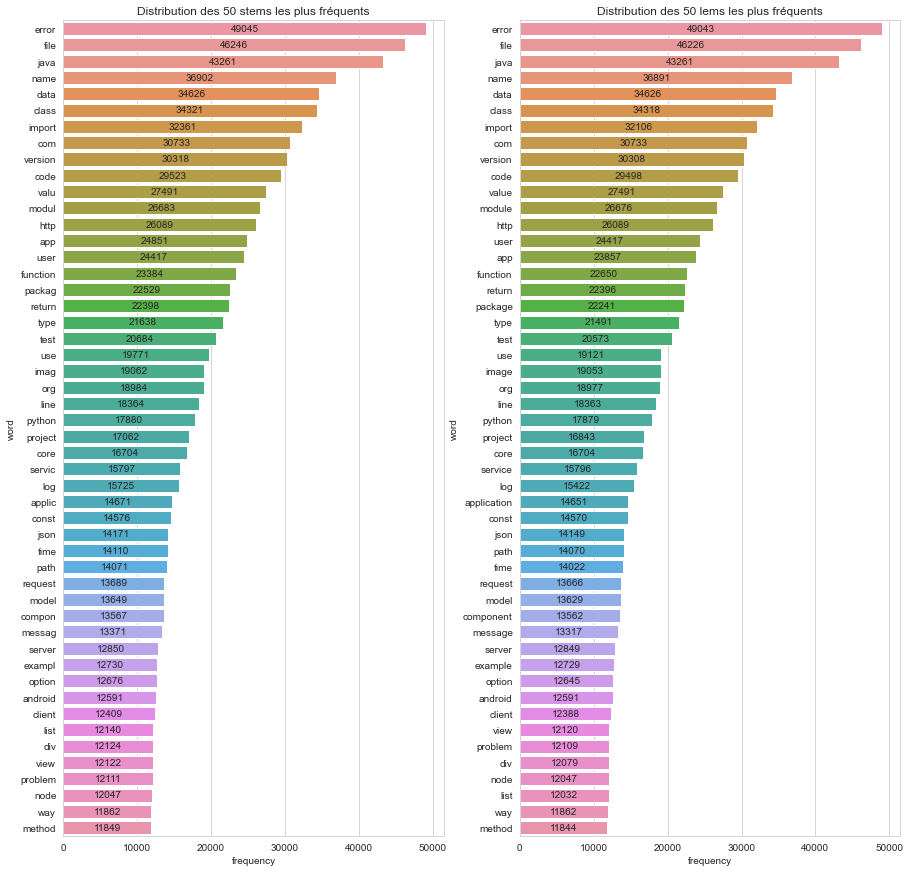

<IPython.core.display.Javascript object>

In [39]:
# Affichage des 50 termes les plus fréquents
f, axes = plt.subplots(1, 2, figsize=(15, 15))
sns.barplot(x=stem_freq.frequency[:50], y=stem_freq.index[:50], ax=axes[0])
axes[0].set_title("Distribution des 50 stems les plus fréquents")
axes[0].bar_label(axes[0].containers[0], label_type="center")

sns.barplot(x=lem_freq.frequency[:50], y=lem_freq.index[:50], ax=axes[1])
axes[1].set_title("Distribution des 50 lems les plus fréquents")
axes[1].bar_label(axes[1].containers[0], label_type="center")
plt.show()

La distribution est quasi similaire, les 16 premiers mots sont les mêmes. Ensuite, l'ordre change un peu.

On va regarder s'il y a des mots différents entre les 2 dans le top 50.

In [40]:
# Stems not in lems
diff_stems = [word for word in stem_freq.index[:50] if word not in lem_freq.index[:50]]
diff_stems

['valu',
 'modul',
 'packag',
 'imag',
 'servic',
 'applic',
 'compon',
 'messag',
 'exampl']

<IPython.core.display.Javascript object>

In [41]:
# Lems not in stems
diff_lems = [word for word in lem_freq.index[:50] if word not in stem_freq.index[:50]]
diff_lems

['value',
 'module',
 'package',
 'image',
 'service',
 'application',
 'component',
 'message',
 'example']

<IPython.core.display.Javascript object>

Il s'agit en fait des mêmes mots dans le top 50, que ce soit des stems ou des lems.

In [43]:
# Nombre de stems ayant une fréquence d'au moins 1000
stem_freq[stem_freq["frequency"] >= 1000].shape[0]

702

<IPython.core.display.Javascript object>

In [44]:
# Nombre de lems ayant une fréquence d'au moins 1000
lem_freq[lem_freq["frequency"] >= 1000].shape[0]

702

<IPython.core.display.Javascript object>

### 2.6. Fréquence de distribution des tags

In [45]:
# Stems tags les plus fréquents
stem_tags_freq = distrib_freq(df_text_tag_1.stemmed_tags)
stem_tags_freq.head(50)

frequency
word                 
python           9060
android          6527
javascript       5028
reactj           3809
java             3475
angular          3320
flutter          3304
net              3224
react            3173
spring           2651
googl            2623
core             2488
docker           2235
node             2120
studio           2100
io               2028
azur             2015
asp              1901
amazon           1866
typescript       1739
web              1549
visual           1512
swift            1413
nativ            1372
dart             1371
vue              1336
laravel          1295
firebas          1192
cloud            1176
html             1171
servic           1148
boot             1137
css              1116
api              1109
kubernet         1107
php              1067
code             1030
swiftui          1018
kotlin           1014
django            988
xcode             883
git               877
panda             873
apach             851
tensorflow        831
materi            819
aw                817
sql               815
window            806
json              724

<IPython.core.display.Javascript object>

In [46]:
# Nombre de stems tags différents
stem_tags_freq.shape[0]

6770

<IPython.core.display.Javascript object>

In [47]:
# Lems tags les plus fréquents
lem_tags_freq = distrib_freq(df_text_tag_1.lemmed_tags)
lem_tags_freq.head(50)

frequency
word                 
python           9060
android          6527
javascript       5028
reactjs          3809
java             3475
angular          3320
flutter          3304
net              3224
react            3173
spring           2651
google           2623
core             2488
docker           2235
node             2120
studio           2100
io               2028
azure            2015
asp              1901
amazon           1866
typescript       1739
web              1549
visual           1466
swift            1413
native           1372
dart             1371
vue              1336
laravel          1295
firebase         1192
cloud            1176
html             1171
service          1148
boot             1137
cs               1116
kubernetes       1107
api              1106
php              1067
code             1023
swiftui          1018
kotlin           1014
django            988
xcode             883
git               877
panda             873
apache            851
tensorflow        831
aws               817
sql               815
material          810
window            806
json              724

<IPython.core.display.Javascript object>

In [48]:
# Nombre de lems tags différents
lem_tags_freq.shape[0]

7293

<IPython.core.display.Javascript object>

On va comparer la distribution des stems tags et des lems tags.

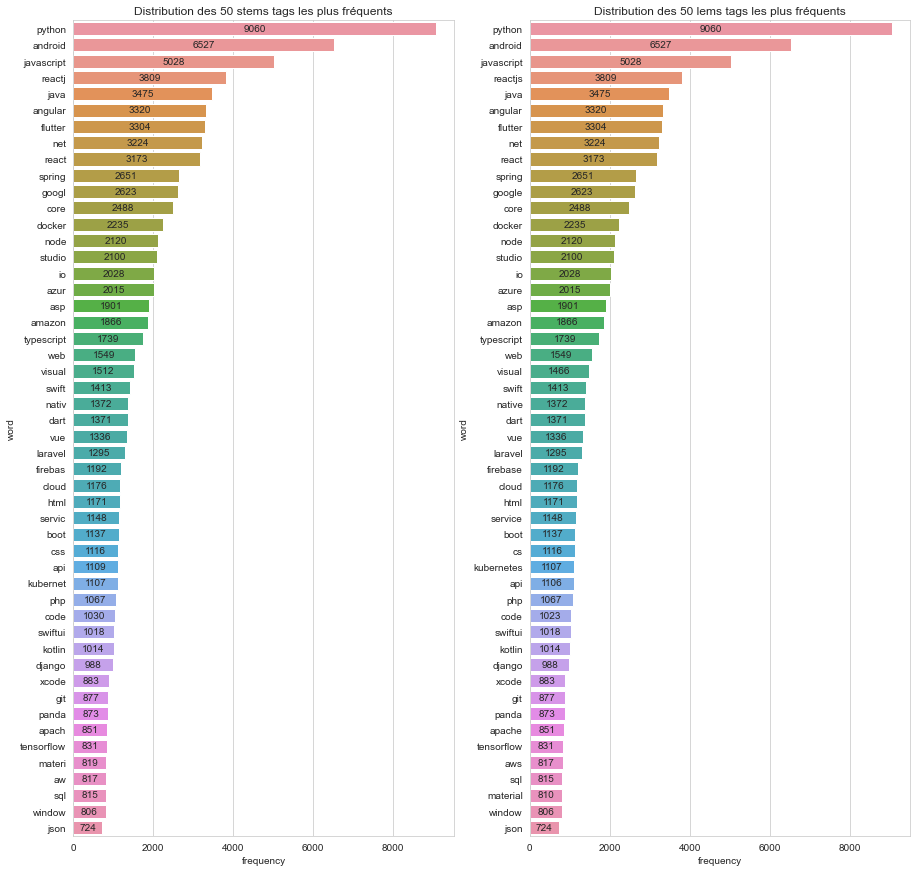

<IPython.core.display.Javascript object>

In [49]:
# Affichage des 50 tags les plus fréquents
f, axes = plt.subplots(1, 2, figsize=(15, 15))
sns.barplot(x=stem_tags_freq.frequency[:50], y=stem_tags_freq.index[:50], ax=axes[0])
axes[0].set_title("Distribution des 50 stems tags les plus fréquents")
axes[0].bar_label(axes[0].containers[0], label_type="center")

sns.barplot(x=lem_tags_freq.frequency[:50], y=lem_tags_freq.index[:50], ax=axes[1])
axes[1].set_title("Distribution des 50 lems tags les plus fréquents")
axes[1].bar_label(axes[1].containers[0], label_type="center")
plt.show()

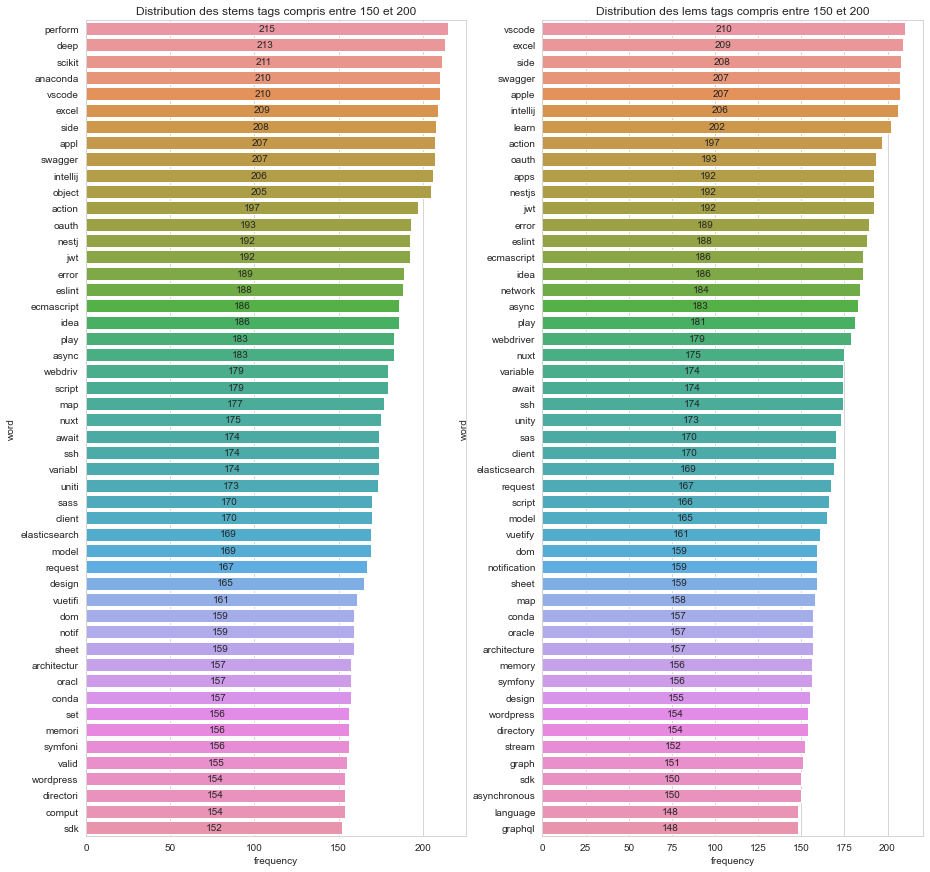

<IPython.core.display.Javascript object>

In [50]:
# Affichage des tags compris entre 150 et 200
f, axes = plt.subplots(1, 2, figsize=(15, 15))
sns.barplot(
    x=stem_tags_freq.frequency[150:200], y=stem_tags_freq.index[150:200], ax=axes[0]
)
axes[0].set_title("Distribution des stems tags compris entre 150 et 200")
axes[0].bar_label(axes[0].containers[0], label_type="center")

sns.barplot(
    x=lem_tags_freq.frequency[150:200], y=lem_tags_freq.index[150:200], ax=axes[1]
)
axes[1].set_title("Distribution des lems tags compris entre 150 et 200")
axes[1].bar_label(axes[1].containers[0], label_type="center")
plt.show()

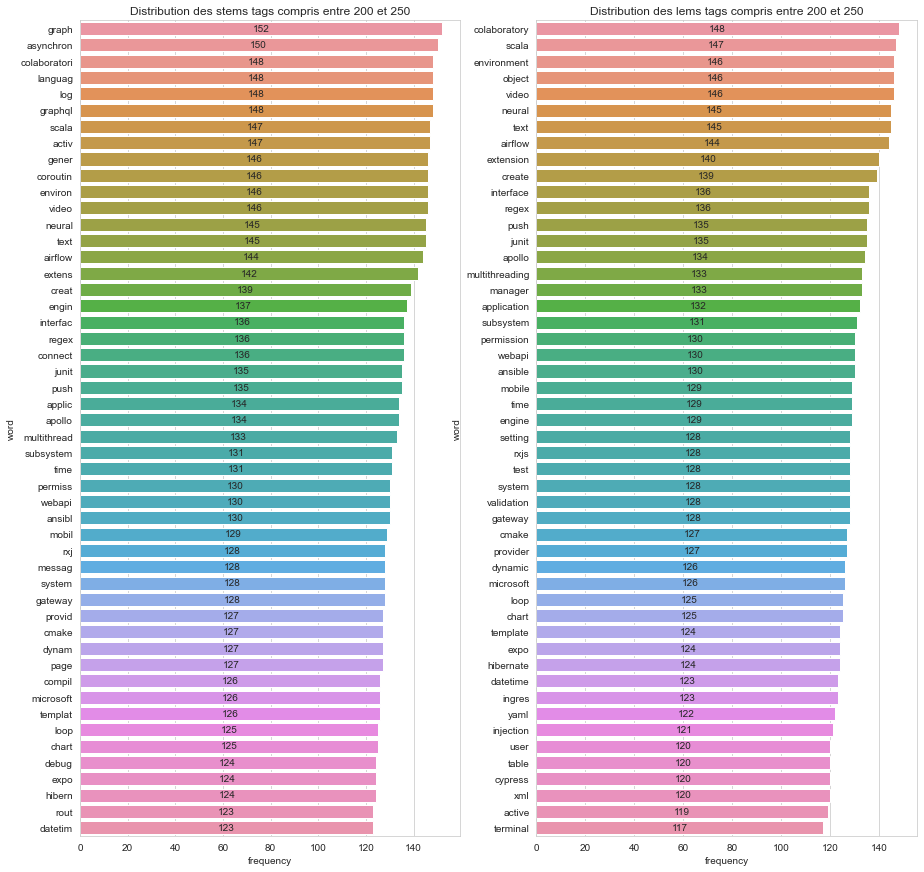

<IPython.core.display.Javascript object>

In [51]:
# Affichage des tags compris entre 200 et 250
f, axes = plt.subplots(1, 2, figsize=(15, 15))
sns.barplot(
    x=stem_tags_freq.frequency[200:250], y=stem_tags_freq.index[200:250], ax=axes[0]
)
axes[0].set_title("Distribution des stems tags compris entre 200 et 250")
axes[0].bar_label(axes[0].containers[0], label_type="center")

sns.barplot(
    x=lem_tags_freq.frequency[200:250], y=lem_tags_freq.index[200:250], ax=axes[1]
)
axes[1].set_title("Distribution des lems tags compris entre 200 et 250")
axes[1].bar_label(axes[1].containers[0], label_type="center")
plt.show()

On va garder la lemmatisation qui va garder une sémantique plus riche.

### 2.7. Filtrage sur le nombre de tags
On va ne garder que les 200 premiers tags, c'est à dire ceux ayant au moins une fréquence de 150 (environ) car ils nous serviront pour les modèles supervisés (donc pour des raisons de performance, on va limiter leur nombre).

In [229]:
# Liste des 200 premiers tags
first_200_tags = lem_tags_freq[0:200].index.to_list()

# Filtrage du dataset sur les 200 premiers tags
df_filt = df_text_tag_1.copy()
df_filt["tags_in_top200"] = df_filt["lemmed_tags"].apply(
    lambda tags: [tag for tag in tags if tag in first_200_tags]
)

<IPython.core.display.Javascript object>

On regarde si il y a des lignes avec aucun tag dans les 200 premiers.

In [230]:
df_filt["len_tags_in_top200"] = df_filt["tags_in_top200"].apply(lambda x: len(x))
df_filt.loc[df_filt["len_tags_in_top200"] == 0]

raw_text  len_text  \
7      Does the C++ standard allow for an uninitializ...       603   
33     Why does glibc's strlen need to be so complica...      1510   
70     Why does this if-statement combining assignmen...        85   
72     Subscribe is deprecated: Use an observer inste...        80   
97     Why do we require requires requires? One of th...       143   
...                                                  ...       ...   
46763  How to read an email's message body using the ...       501   
46777  Find min and max of a column given an ordered ...       207   
46778  Neo4J how to call db.index.fulltext.queryNodes...       145   
46787  MongooseIM mod_event_pusher RabbitMQ I trying ...       112   
46799  Windows context menu "send to" EditPlus has wr...       101   

                                                raw_tags  \
7      <c++><llvm><undefined-behavior><abi><llvm-code...   
33         <c><optimization><glibc><portability><strlen>   
70                                   <c++><if-statement>   
72       <callback><rxjs><deprecated><tslint><subscribe>   
97                            <c++><c++-concepts><c++20>   
...                                                  ...   
46763                                         <go><imap>   
46777                              <r><dplyr><tidyverse>   
46778                  <neo4j><cypher><full-text-search>   
46787                      <rabbitmq><xmpp><mongoose-im>   
46799                              <clearcase><editplus>   

                                            stemmed_text  \
7      [bool, crash, program, compil, anyth, crash, c...   
33     [glibc, strlen, code, optim, code, exampl, som...   
70     [statement, equal, return, think, beginn, mist...   
72     [subscrib, callback, run, linter, subscrib, ca...   
97     [requir, corner, situat, instanc, exampl, req,...   
...                                                  ...   
46763  [messag, bodi, messag, emers, imap, email, one...   
46777  [column, index, dplyr, vector, index, tidyvers...   
46778  [index, fulltext, node, search, node, data, mo...   
46787  [mongooseim, event, pusher, rabbitmq, mongoose...   
46799  [window, send, editplu, path, clearcas, explor...   

                                             lemmed_text  \
7      [bool, crash, program, compiler, anything, cra...   
33     [glibc, strlen, code, optimization, code, exam...   
70     [statement, equality, return, thinking, beginn...   
72     [subscribe, callback, run, linter, subscribe, ...   
97     [require, corner, situation, instance, example...   
...                                                  ...   
46763  [message, body, message, emersion, imap, email...   
46777  [column, index, dplyr, vector, index, tidyvers...   
46778  [index, fulltext, node, search, node, data, mo...   
46787  [mongooseim, event, pusher, rabbitmq, mongoose...   
46799  [window, send, editplus, path, clearcase, expl...   

       len_preprocessed_text                                   stemmed_tags  \
7                        149  [llvm, undefin, behavior, abi, llvm, codegen]   
33                       240                [optim, glibc, portabl, strlen]   
70                        16                                    [statement]   
72                        21      [callback, rxj, deprec, tslint, subscrib]   
97                        22                                      [concept]   
...                      ...                                            ...   
46763                    109                                         [imap]   
46777                     43                              [dplyr, tidyvers]   
46778                     43              [neo, cypher, full, text, search]   
46787                     46                      [rabbitmq, xmpp, mongoos]   
46799                     31                            [clearcas, editplu]   

                                           lemmed_tags  len_preprocessed_tags  \
7      [llvm, 

<IPython.core.display.Javascript object>

On va supprimer ces lignes soit 4.9% du dataset.

In [231]:
df_filt1 = df_filt.loc[df_filt["len_tags_in_top200"] > 0]
df_filt1 = df_filt1.reset_index(drop=True)
df_filt1

raw_text  len_text  \
0      Support for password authentication was remove...        91   
1      How to fix "ReferenceError: primordials is not...        95   
2      Xcode 12, building for iOS Simulator, but link...       181   
3      Why is the result of ('b'+'a'+ + 'a' + 'a').to...        40   
4      How to deal with this git warning? "Pulling wi...       175   
...                                                  ...       ...   
44493  The ComposeView adapter does not work in a var...        46   
44494  How do I undo a merge , after I merged a branc...        90   
44495  ReactJS - You may need an appropriate loader t...        98   
44496  CSS, use @supports to detect @font-face suppor...       101   
44497  Field 'last_login' expected a number but got d...       617   

                                                raw_tags  \
0             <git><github><token><github-api><git-pull>   
1                       <node.js><sass><gulp><gulp-sass>   
2      <ios><xcode><xcode12><xcode12beta5><xcode12beta6>   
3                          <javascript><type-conversion>   
4                                                  <git>   
...                                                  ...   
44493                 <android><android-jetpack-compose>   
44494  <version-control><git-merge><atlassian-sourcet...   
44495                                          <reactjs>   
44496    <css><conditional-statements><font-face><check>   
44497                                           <django>   

                                            stemmed_text  \
0      [support, password, authent, pleas, use, acces...   
1      [referenceerror, primordi, node, modul, gulp, ...   
2      [xcode, io, simul, file, architectur, arm, xco...   
3      [result, tolowercas, banana, javascript, javas...   
4      [deal, git, diverg, branch, pull, origin, mast...   
...                                                  ...   
44493  [composeview, adapt, work, variant, problem, c...   
44494  [merg, branch, master, branch, guy, branch, ma...   
44495  [reactj, loader, handl, file, type, error, use...   
44496  [css, use, support, face, support, use, suppor...   
44497  [field, login, number, face, problem, django, ...   

                                             lemmed_text  \
0      [support, password, authentication, please, us...   
1      [referenceerror, primordials, node, module, gu...   
2      [xcode, io, simulator, file, architecture, arm...   
3      [result, tolowercase, banana, javascript, java...   
4      [deal, git, divergent, branch, pull, origin, m...   
...                                                  ...   
44493  [composeview, adapter, work, variant, problem,...   
44494  [merge, branch, master, branch, guy, branch, m...   
44495  [reactjs, loader, handle, file, type, error, u...   
44496  [cs, use, support, face, support, use, support...   
44497  [field, login, number, face, probleme, django,...   

       len_preprocessed_text  \
0                         28   
1                         22   
2                         50   
3                         12   
4                         50   
...                      ...   
44493                     14   
44494                     22   
44495                     21   
44496                     37   
44497                    186   

                                            stemmed_tags  \
0           [git, github, token, github, api, git, pull]   
1                         [node, sass, gulp, gulp, sass]   
2           [io, xcode, xcode, xcode, beta, xcode, beta]   
3                            [javascript, type, convers]   
4                                                  [git]   
...                                                  ...   
44493                [android, android, jetpack, compos]   
44494  [version, control, git, merg, atlassian, sourc...   
44495                                           [reactj]   
44496        [css, condit, statement, font, face, check]   

<IPython.core.display.Javascript object>

In [232]:
# Export au format csv
df_filt1.to_csv("./data/df_filt_text_1.csv")

<IPython.core.display.Javascript object>

In [233]:
# Save to pickle
df_filt1.to_pickle("./model/df_filt_text_1.pkl")

<IPython.core.display.Javascript object>

In [12]:
# Load
df_filt1 = pd.read_pickle("./model/df_filt_text_1.pkl")
df_filt1

raw_text  len_text  \
0      Support for password authentication was remove...        91   
1      How to fix "ReferenceError: primordials is not...        95   
2      Xcode 12, building for iOS Simulator, but link...       181   
3      Why is the result of ('b'+'a'+ + 'a' + 'a').to...        40   
4      How to deal with this git warning? "Pulling wi...       175   
...                                                  ...       ...   
44493  The ComposeView adapter does not work in a var...        46   
44494  How do I undo a merge , after I merged a branc...        90   
44495  ReactJS - You may need an appropriate loader t...        98   
44496  CSS, use @supports to detect @font-face suppor...       101   
44497  Field 'last_login' expected a number but got d...       617   

                                                raw_tags  \
0             <git><github><token><github-api><git-pull>   
1                       <node.js><sass><gulp><gulp-sass>   
2      <ios><xcode><xcode12><xcode12beta5><xcode12beta6>   
3                          <javascript><type-conversion>   
4                                                  <git>   
...                                                  ...   
44493                 <android><android-jetpack-compose>   
44494  <version-control><git-merge><atlassian-sourcet...   
44495                                          <reactjs>   
44496    <css><conditional-statements><font-face><check>   
44497                                           <django>   

                                            stemmed_text  \
0      [support, password, authent, pleas, use, acces...   
1      [referenceerror, primordi, node, modul, gulp, ...   
2      [xcode, io, simul, file, architectur, arm, xco...   
3      [result, tolowercas, banana, javascript, javas...   
4      [deal, git, diverg, branch, pull, origin, mast...   
...                                                  ...   
44493  [composeview, adapt, work, variant, problem, c...   
44494  [merg, branch, master, branch, guy, branch, ma...   
44495  [reactj, loader, handl, file, type, error, use...   
44496  [css, use, support, face, support, use, suppor...   
44497  [field, login, number, face, problem, django, ...   

                                             lemmed_text  \
0      [support, password, authentication, please, us...   
1      [referenceerror, primordials, node, module, gu...   
2      [xcode, io, simulator, file, architecture, arm...   
3      [result, tolowercase, banana, javascript, java...   
4      [deal, git, divergent, branch, pull, origin, m...   
...                                                  ...   
44493  [composeview, adapter, work, variant, problem,...   
44494  [merge, branch, master, branch, guy, branch, m...   
44495  [reactjs, loader, handle, file, type, error, u...   
44496  [cs, use, support, face, support, use, support...   
44497  [field, login, number, face, probleme, django,...   

       len_preprocessed_text  \
0                         28   
1                         22   
2                         50   
3                         12   
4                         50   
...                      ...   
44493                     14   
44494                     22   
44495                     21   
44496                     37   
44497                    186   

                                            stemmed_tags  \
0           [git, github, token, github, api, git, pull]   
1                         [node, sass, gulp, gulp, sass]   
2           [io, xcode, xcode, xcode, beta, xcode, beta]   
3                            [javascript, type, convers]   
4                                                  [git]   
...                                                  ...   
44493                [android, android, jetpack, compos]   
44494  [version, control, git, merg, atlassian, sourc...   
44495                                           [reactj]   
44496        [css, condit, statement, font, face, check]   

<IPython.core.display.Javascript object>

### 2.8. Liste des mots gardés
On va transformer les tokens en vecteurs afin de pouvoir les utiliser dans les modèles de machine learning. On va donc conserver qu'un certain nombre de lems pour éviter d'avoir trop de variables à traiter.

On va regarder la distribution des lems sur le nouveau dataset.

In [4]:
# Fréquence des lems
lem_freq2 = distrib_freq(df_filt1.lemmed_text)

<IPython.core.display.Javascript object>

In [10]:
# Nombre de lems ayant une fréquence d'au moins 1000
lem_freq2[lem_freq2["frequency"] >= 1000].shape[0]

678

<IPython.core.display.Javascript object>

In [11]:
# Nombre de lems ayant une fréquence d'au moins 1400
lem_freq2[lem_freq2["frequency"] >= 1400].shape[0]

514

<IPython.core.display.Javascript object>

Avec une occurence de 1000, on a autour de 678 mots. On va plutôt partir sur les mots ayant une occurence d'au moins 1400. On obtient ainsi 514 mots.

In [12]:
# Récupération de la liste des mots
# avec une occurence d'au moins 1400
list_words = list(lem_freq2[lem_freq2["frequency"] >= 1400].index)
len(list_words)

514

<IPython.core.display.Javascript object>

In [13]:
list_words

['error',
 'file',
 'java',
 'name',
 'class',
 'data',
 'import',
 'com',
 'version',
 'code',
 'value',
 'module',
 'http',
 'user',
 'app',
 'package',
 'function',
 'return',
 'type',
 'test',
 'image',
 'org',
 'use',
 'python',
 'line',
 'project',
 'core',
 'service',
 'log',
 'application',
 'const',
 'json',
 'path',
 'request',
 'component',
 'model',
 'time',
 'android',
 'message',
 'server',
 'option',
 'div',
 'view',
 'example',
 'client',
 'node',
 'list',
 'problem',
 'var',
 'default',
 'method',
 'way',
 'docker',
 'system',
 'work',
 'state',
 'dependency',
 'index',
 'react',
 'item',
 'color',
 'result',
 'command',
 'spring',
 'text',
 'page',
 'lib',
 'response',
 'button',
 'script',
 'input',
 'api',
 'output',
 'size',
 'get',
 'container',
 'flutter',
 'springframework',
 'issue',
 'google',
 'config',
 'release',
 'site',
 'access',
 'task',
 'jar',
 'int',
 'string',
 'event',
 'style',
 'create',
 'src',
 'change',
 'info',
 'form',
 'property',
 'excepti

<IPython.core.display.Javascript object>

In [14]:
df_list_words = pd.DataFrame(list_words, columns=["word"])

# Save to pickle
df_list_words.to_pickle("./model/list_words2.pkl")

<IPython.core.display.Javascript object>

In [15]:
# Persistence with joblib
filename_list_words = "./models/list_words2.joblib"
joblib.dump(list_words, filename_list_words)

['./models/list_words2.joblib']

<IPython.core.display.Javascript object>

In [16]:
# Chargement de la liste des 514 mots
list_words = joblib.load("./models/list_words2.joblib")
list_words

['error',
 'file',
 'java',
 'name',
 'class',
 'data',
 'import',
 'com',
 'version',
 'code',
 'value',
 'module',
 'http',
 'user',
 'app',
 'package',
 'function',
 'return',
 'type',
 'test',
 'image',
 'org',
 'use',
 'python',
 'line',
 'project',
 'core',
 'service',
 'log',
 'application',
 'const',
 'json',
 'path',
 'request',
 'component',
 'model',
 'time',
 'android',
 'message',
 'server',
 'option',
 'div',
 'view',
 'example',
 'client',
 'node',
 'list',
 'problem',
 'var',
 'default',
 'method',
 'way',
 'docker',
 'system',
 'work',
 'state',
 'dependency',
 'index',
 'react',
 'item',
 'color',
 'result',
 'command',
 'spring',
 'text',
 'page',
 'lib',
 'response',
 'button',
 'script',
 'input',
 'api',
 'output',
 'size',
 'get',
 'container',
 'flutter',
 'springframework',
 'issue',
 'google',
 'config',
 'release',
 'site',
 'access',
 'task',
 'jar',
 'int',
 'string',
 'event',
 'style',
 'create',
 'src',
 'change',
 'info',
 'form',
 'property',
 'excepti

<IPython.core.display.Javascript object>

## 3. Préparation des données
### 3.1. Split des données
On va splitter les données entre le jeu de train et le jeu d'entrainement.

In [13]:
# 80% des données dans le jeu d'entrainement et 20% dans le jeu de test
train_set, test_set = train_test_split(df_filt1, test_size=0.2, random_state=42)
print("Taille de train_set : {}".format(train_set.shape))
print("Taille de test_set : {}".format(test_set.shape))

Taille de train_set : (35598, 11)
Taille de test_set : (8900, 11)


<IPython.core.display.Javascript object>

In [14]:
# Reset de l'index
train_set = train_set.reset_index(drop = True)
test_set = test_set.reset_index(drop = True)

<IPython.core.display.Javascript object>

In [15]:
# Récupération du corpus sous forme d'une liste de textes
# 1 ligne = 1 seul string
train_corpus = train_set["lemmed_text"].apply(lambda x: " ".join(x)).to_list()

test_corpus = test_set["lemmed_text"].apply(lambda x: " ".join(x)).to_list()

<IPython.core.display.Javascript object>

In [31]:
# Persistence with joblib for MLFlow
filename_train_corpus = "./models/train_corpus.joblib"
joblib.dump(train_corpus, filename_train_corpus)

['./models/train_corpus.joblib']

<IPython.core.display.Javascript object>

In [32]:
# Persistence with joblib for MLFlow
filename_train_set = "./models/train_set.joblib"
joblib.dump(train_set, filename_train_set)

['./models/train_set.joblib']

<IPython.core.display.Javascript object>

### 3.2. TF-IDF
Cette méthode permet de pondérer la fréquence d'un mot dans un document selon sa fréquence dans les autres documents du corpus. Ainsi on diminue la fréquence de mots présents dans de nombreux documents. 

Cette méthode est adaptée ici car on a beaucoup de termes génériques et des documents de taille variable.

In [16]:
# Création du vectorizer
vectorizer_tfidf = TfidfVectorizer(analyzer="word", vocabulary=list_words)

# Entrainement du modèle
train_corpus_tfidf = vectorizer_tfidf.fit_transform(train_corpus)

<IPython.core.display.Javascript object>

## 4. Approche non supervisée : LDA

On va essayer de trouver les tags de manière non supervisée en utilisant l'algorithme de Dirichlet : Latent Dirichlet Allocation (LDA). Cet algorithme va générer des topics avec un certain nombre de mots associés.
### 4.1. GridSearch
On va faire une recherche d'hyperparamètres avec un GridSearch. Cette méthode prend du temps.

In [21]:
%%time
lda = LatentDirichletAllocation(learning_method="online", n_jobs=-1, random_state=0)

# Dictionnaire d'hyperparamètres
hyper_params = {"n_components": [4, 5, 6, 7, 8, 9, 10, 15, 20, 30]}

# initialiser la validation croisée
grid = GridSearchCV(lda, param_grid=hyper_params)

# entrainement du modèle
grid.fit(train_corpus_tfidf)

# Meilleur modèle
best_lda_model = grid.best_estimator_

# Affichage des meilleurs paramètres
print("Best paramètres : ")
for params, val in grid.best_params_.items():
    print(" - ", params, ":", val)

# Récupération du best score Log Likelyhood (Higher the better)
log_like = grid.best_score_

# Récupération du best score Perplexity (Lower the better)
# Perplexity = exp(-1. * log-likelihood per word))
perplexity = best_lda_model.perplexity(train_corpus_tfidf)

# Récupération du temps d'entrainement du modèle
mean_time = grid.cv_results_["mean_fit_time"][grid.best_index_]

# Affichage des résultats
print("- Log Likelyhood : {:.1f}".format(log_like))
print("- perplexity : {:.1f}".format(perplexity))
print("- Temps d'entrainement : {:.4f} s \n".format(mean_time))

Best paramètres : 
 -  n_components : 4
- Log Likelyhood : -161114.1
- perplexity : 571.6
- Temps d'entrainement : 30.5390 s 

CPU times: user 9min 2s, sys: 47.3 s, total: 9min 50s
Wall time: 25min 27s


<IPython.core.display.Javascript object>

On va essayer de relancer le grid search en prenant comme scoring la perplexity

In [22]:
# Création d'une nouvelle fonction LDA avc scoring basé sur perplexity
class MyLDAWithPerplexityScorer(LatentDirichletAllocation):

    def score(self, X, y=None):

        # You can change the options passed to perplexity here
        score = super(MyLDAWithPerplexityScorer, self).perplexity(X, sub_sampling=False)

        # Since perplexity is lower for better, so we do negative
        return -1*score

<IPython.core.display.Javascript object>

In [23]:
%%time

# Nouvel objet LDA
lda_perplx = MyLDAWithPerplexityScorer(learning_method="online", n_jobs=-1, random_state=0)

# Dictionnaire d'hyperparamètres
hyper_params = {"n_components": [4, 5, 6, 7, 8, 9, 10, 15, 20, 30]}

# initialiser la validation croisée
grid_perplx = GridSearchCV(lda_perplx, param_grid=hyper_params)

# entrainement du modèle
grid_perplx.fit(train_corpus_tfidf)

# Meilleur modèle
best_lda_model_perplx = grid_perplx.best_estimator_

# Affichage des meilleurs paramètres
print("Best paramètres avec perplexity : ")
for params, val in grid_perplx.best_params_.items():
    print(" - ", params, ":", val)

# Récupération du best score Perplexity (Higher the better)
perplexity_perplx = grid_perplx.best_score_

# Récupération du temps d'entrainement du modèle
mean_time_perplx = grid_perplx.cv_results_["mean_fit_time"][grid_perplx.best_index_]

# Affichage des résultats
print("- perplexity : {:.1f}".format(perplexity_perplx))
print("- Temps d'entrainement : {:.4f} s \n".format(mean_time_perplx))

Best paramètres avec perplexity : 
 -  n_components : 4
- perplexity : -656.3
- Temps d'entrainement : 30.1945 s 

CPU times: user 9min 7s, sys: 47.7 s, total: 9min 55s
Wall time: 25min 44s


<IPython.core.display.Javascript object>

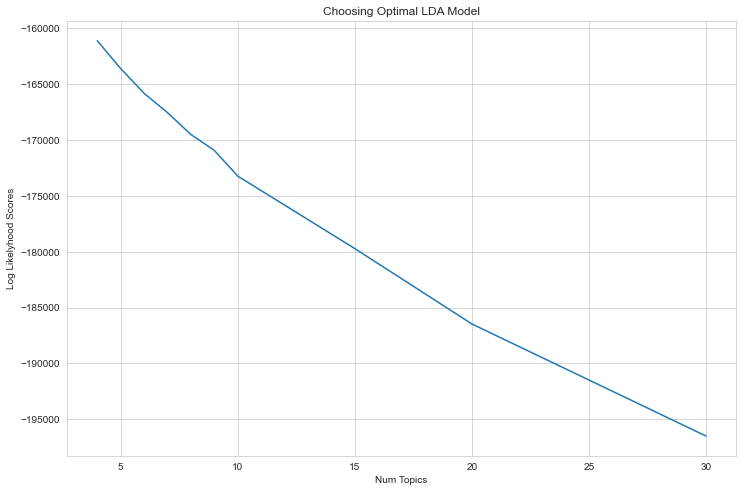

<IPython.core.display.Javascript object>

In [24]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [4, 5, 6, 7, 8, 9, 10, 15, 20, 30]
log_likelyhoods = [round(gscore) for gscore in grid.cv_results_["mean_test_score"]]

# Visualisation ds scores de log-like
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods)
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.show()

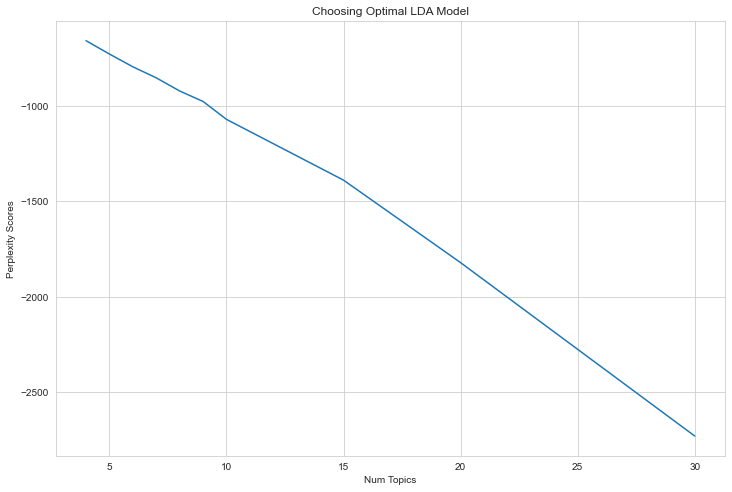

<IPython.core.display.Javascript object>

In [25]:
# Get perplexity from Grid Search Output
n_topics = [4, 5, 6, 7, 8, 9, 10, 15, 20, 30]
perplexity_list = [round(gscore) for gscore in grid_perplx.cv_results_["mean_test_score"]]

# Visualisation ds scores de perplexity
plt.figure(figsize=(12, 8))
plt.plot(n_topics, perplexity_list)
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("- Perplexity Scores")
plt.show()

On obtient quasiment les mêmes résultats. On va partir sur le best modèle trouvé par grid search avec le log-like comme score.

In [26]:
# Persistence with joblib
filename_best_lda_model = "./models/best_lda_model2.joblib"
joblib.dump(best_lda_model, filename_best_lda_model)

['./models/best_lda_model2.joblib']

<IPython.core.display.Javascript object>

Remarque : après recherche sur internet, pour le modèle LDA, la meilleur métrique est le score de cohérence, non disponible sur scikit-learn, mais disponible via la librairie Gensim. Par manque de temps, cette librairie n'a pas été testée.

### 4.2. Récupération des topics et des mots associés

In [2]:
def display_topics(model, words, n_top_words):

    """ Fonction pour afficher les topics trouvés par un modèle, 
    ainsi qu'un nombre de mots associés et stocke ces informations 
    dans un dictionnaire
        
    - Arguments :
        - model : modèle qui génère les topics
        - words : mots en eux mêmes qui sont associés au comptage, 
        puisés dans une liste
        - nb_top_words : nombre maximum de mots par topic
    
    - Affiche :
        - pour chaque topic : liste des mots associés
    
    - Retourne :
        - un dictionnaire : clé = numéro de topic,
        valeur = liste des mots associés
    """

    # Disctionnaire des topics avec liste de mots correspondants
    dico_topic = {}

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [words[i] for i in top_features_ind]
        print("Topic {}:".format(topic_idx + 1))
        print(" ".join(top_features))
        dico_topic.update({topic_idx: top_features})

    return dico_topic

<IPython.core.display.Javascript object>

In [28]:
# Récupération des 20 premiers mots par topic
dico_topic_lda = display_topics(best_lda_model, list_words, 20)

Topic 1:
java docker flutter android com version io app spring container org google device error image application class widget boot project
Topic 2:
file python package version line error command project import code module model image path install window test studio program folder
Topic 3:
error request module http json response client service app function server node log user api file import application access password
Topic 4:
value data class color button view component item function list return div name text type column import state number array


<IPython.core.display.Javascript object>

On récupère également un dictionnaire avec les 50 premiers mots pour chaque topic en vue de la comparaison avec les modèles supervisés.

In [29]:
# Récupération des 50 premiers mots par topic
dico_topic_lda_50 = display_topics(best_lda_model, list_words, 50)

Topic 1:
java docker flutter android com version io app spring container org google device error image application class widget boot project service video dart notification pod dependency name apple firebase implementation permission release file build http certificate test apache jar springframework tab studio plugin support activity fun exception volume context kotlin
Topic 2:
file python package version line error command project import code module model image path install window test studio program folder site lib user directory script output git use github name pip system bin environment time job way run csv problem layer pipeline data source work download step train issue print
Topic 3:
error request module http json response client service app function server node log user api file import application access password message page data react code use const core azure connection database com header php post type test route browser return option project name config err login script 

<IPython.core.display.Javascript object>

In [30]:
# Palette de couleurs pour assigner même couleur à un topic
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

<IPython.core.display.Javascript object>

In [31]:
def plot_top_words(model, words, n_top_words, title, row_subplot, col_subplot):

    """ Fonction pour représenter graphiquement la répartition des
    mots par topic, sous forme de barplot
        
    - Arguments :
        - model : modèle qui génère les topics
        - words : mots en eux mêmes qui sont associés au comptage
        - nb_top_words : nombre maximum de mots par topic
        - title : titre à donner au graphe (string)
    
    - Affiche :
        - autant de graphes que de topics
        - pour chaque topic : liste des mots associés sous forme
        de barplot
    """

    fig, axes = plt.subplots(row_subplot, col_subplot, figsize=(30, 16), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [words[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7, color=cols[topic_idx])
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.bar_label(ax.containers[0], size=20)
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

<IPython.core.display.Javascript object>

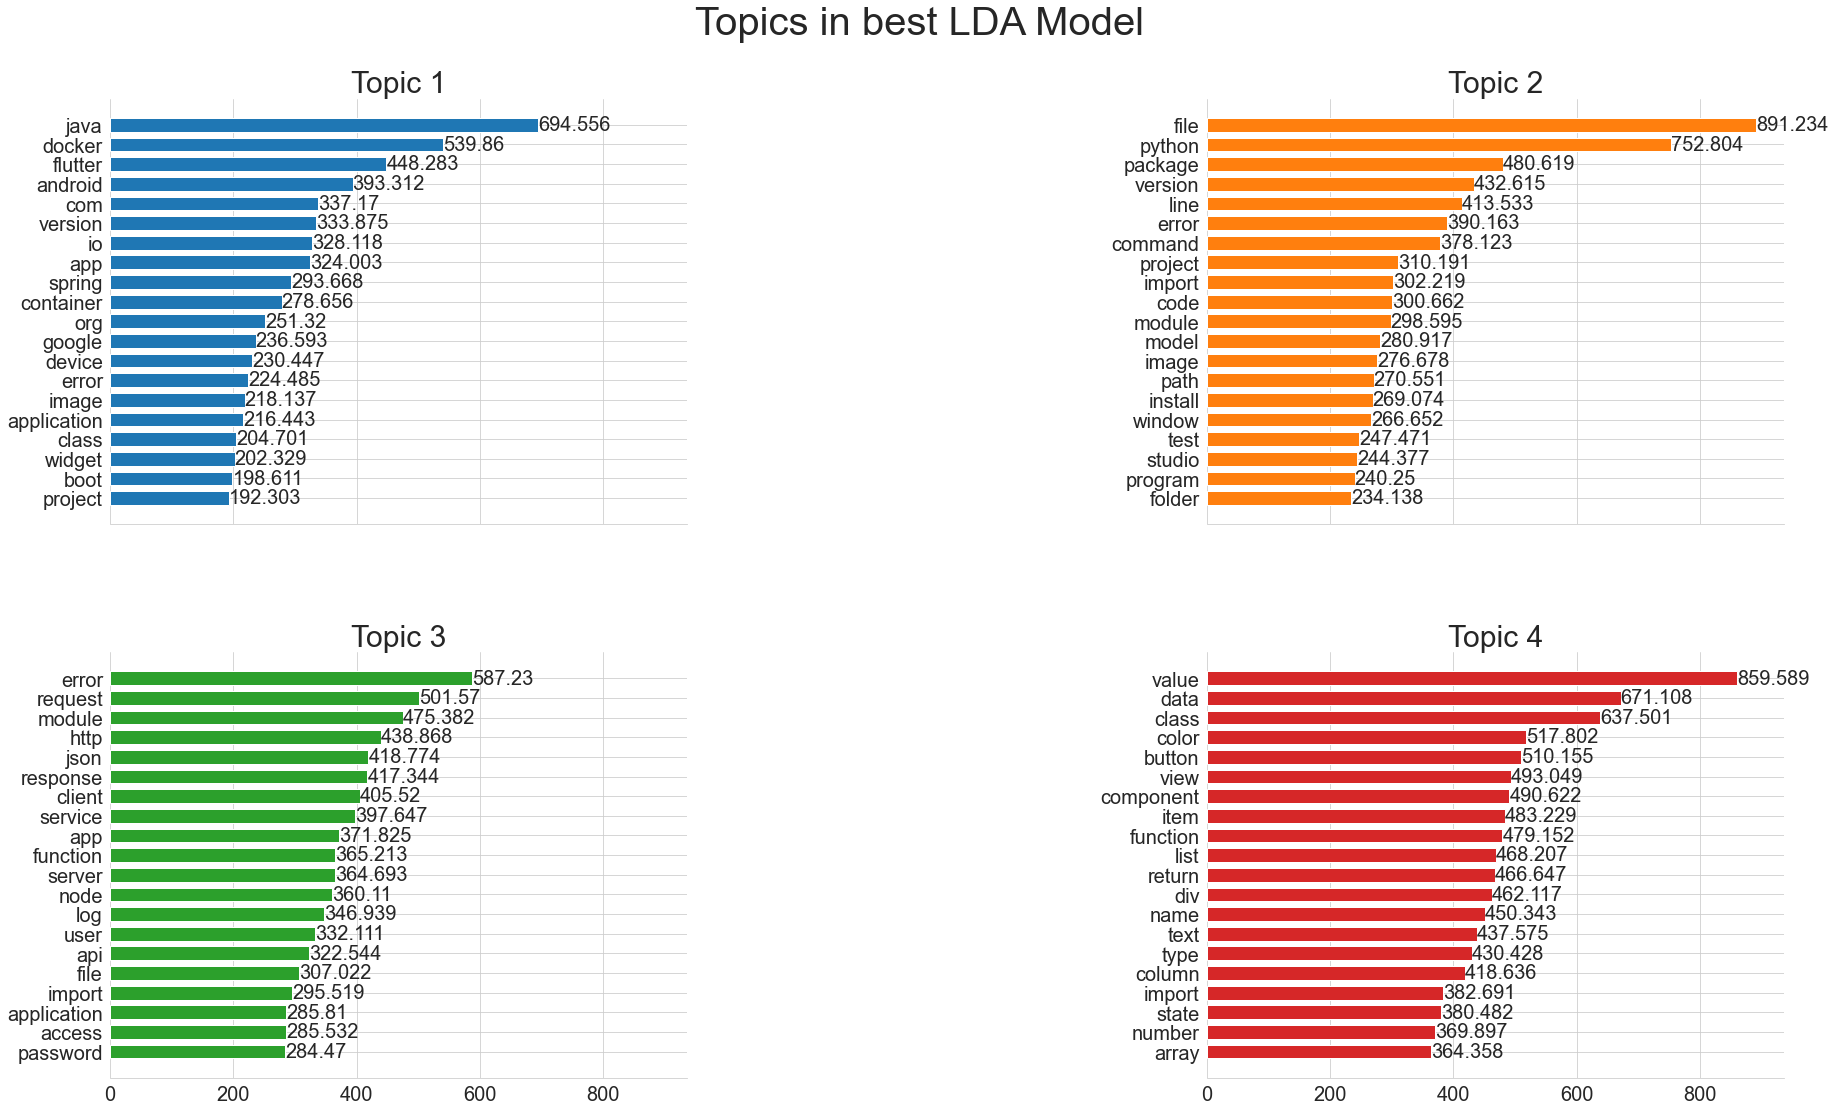

<IPython.core.display.Javascript object>

In [32]:
plot_top_words(best_lda_model, list_words, 20, "Topics in best LDA Model", 2, 2)

LDA nous propose 4 topics, ce n'est pas optimal. Les topics sont assez génériques. On peut essayer de leur attribuer une thématique
- Topic 1 : application
- Topic 2 : environnement de développement 
- Topic 3 : lien entre applications
- Topic 4 : développement

### 4.3. Comparaison avec NMF
On va regarder avec NMF (Non Negative Matrix Factorization).

In [33]:
nmf = NMF(n_components=4, random_state=1, alpha=0.1, l1_ratio=0.5, init="nndsvd").fit(
    train_corpus_tfidf
)
# Nonnegative Double Singular Value Decomposition (NNDSVD) initialization (better for sparseness)

<IPython.core.display.Javascript object>

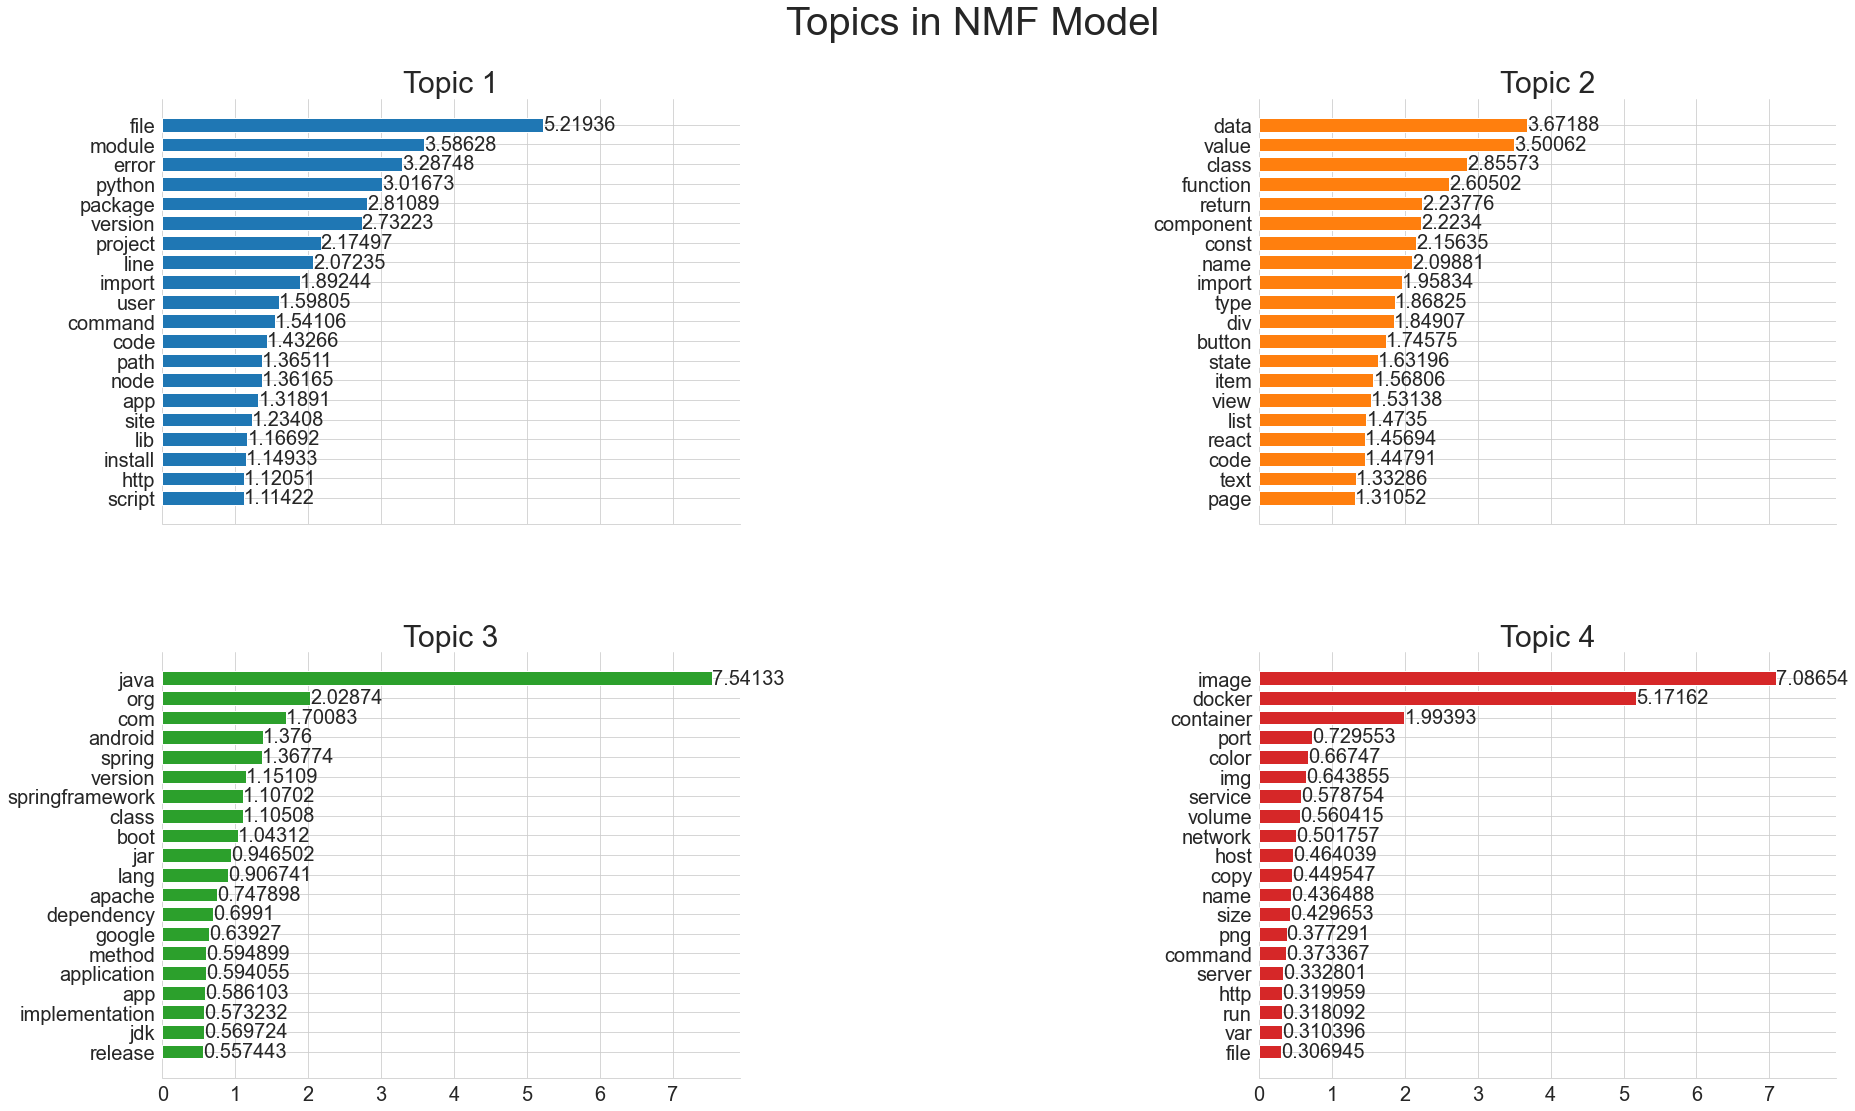

<IPython.core.display.Javascript object>

In [34]:
plot_top_words(nmf, list_words, 20, "Topics in NMF Model", 2, 2)

On retombe un peu sur les mêmes topics, mais ici des mots se détachent plus que d'autres. Mais n'ayant pas de métriques à disposition, il est difficile de comparer les méthodes.

### 4.4. Répartition des topics

In [35]:
def df_output_topics(model, data_tfidf, dico_topic):

    """ Fonction pour récupérer dans un dataframe le topic principal
    d'un text, avec la probabilité associée et les tags associés, et également 
    la sortie (= transform) du modèle
        
    - Arguments :
        - model : modèle qui génère les topics
        - data_tfidf : dataframe contenant les données sous forme tfidf
        - dico_topic : dictionnaire contenant les topics et les mots dans le topic
    
    - Retourne :
        - un dataframe avec le numéro du topic, la probabilité associée
        et la liste des mots associés au topic
        - un array avec le poids de chaque topic pour chaque texte
    """

    # Initialisation du dataframe
    df_topic = pd.DataFrame()

    # Récupération du poids de chaque topic
    model_output = model.transform(data_tfidf)

    # Pour chaque ligne du dataframe tfidf (donc chaque texte)
    for i in range(0, data_tfidf.shape[0]):
        # Numéro du topic
        topic_nb = model_output[i, :].argsort()[-1]
        # Pourcentage associé à ce topic
        topic_perc = model_output[i, :].max()

        # Ajout des données au dataframe
        # dico_topic[topic_nb] = liste de mots du topic associé
        df_topic = df_topic.append(
            pd.Series([int(topic_nb + 1), round(topic_perc, 4), dico_topic[topic_nb]]),
            ignore_index=True,
        )

    df_topic.columns = ["main_topic", "topic_perc", "topic_words"]

    return df_topic, model_output

<IPython.core.display.Javascript object>

In [36]:
# Dataframe avec le main topic associé à chaque texte
# avec seulement 20 mots par topics
df_topic_20, best_lda_output = df_output_topics(
    best_lda_model, train_corpus_tfidf, dico_topic_lda
)

# Dataframe avec le main topic associé à chaque texte
# avec 50 mots par topics
df_topic_50, best_lda_output = df_output_topics(
    best_lda_model, train_corpus_tfidf, dico_topic_lda_50
)

<IPython.core.display.Javascript object>

In [37]:
# On rajoute le texte d'origine et les tags sous forme de lems
df_topic_text_20 = pd.concat(
    [df_topic_20, train_set.raw_text, train_set.lemmed_tags,], axis=1,
)
df_topic_text_20

main_topic  topic_perc  \
0             4.0      0.5214   
1             1.0      0.7646   
2             3.0      0.6816   
3             2.0      0.7890   
4             3.0      0.8320   
...           ...         ...   
35593         4.0      0.7421   
35594         2.0      0.5863   
35595         4.0      0.6544   
35596         1.0      0.7989   
35597         4.0      0.4495   

                                             topic_words  \
0      [value, data, class, color, button, view, comp...   
1      [java, docker, flutter, android, com, version,...   
2      [error, request, module, http, json, response,...   
3      [file, python, package, version, line, error, ...   
4      [error, request, module, http, json, response,...   
...                                                  ...   
35593  [value, data, class, color, button, view, comp...   
35594  [file, python, package, version, line, error, ...   
35595  [value, data, class, color, button, view, comp...   
35596  [java, docker, flutter, android, com, version,...   
35597  [value, data, class, color, button, view, comp...   

                                                raw_text  \
0      ROC function error "Predictor must be numeric ...   
1      terraform kubectl provider not found I'm tryin...   
2      How to create a directory and add files to ipf...   
3      How do you add Font Awesome to Ionic 4 There a...   
4      How do I save an object in IndexedDB? I want t...   
...                                                  ...   
35593  What is the difference between tokio::spawn(my...   
35594  Fastest way to read large Excel xlsx files? To...   
35595  Separate panels in mplfinance I would like to ...   
35596  Could not find module for target 'x86_64-apple...   
35597  Typescript: 'new' expression, whose target lac...   

                                             lemmed_tags  
0                                   [roc, proc, package]  
1      [kubernetes, terraform, kubectl, terraform, pr...  
2                               [javascript, ipfs, ipfs]  
3               [ionic, framework, font, awesome, ionic]  
4                                [javascript, indexeddb]  
...                                                  ...  
35593                                [rust, rust, tokio]  
35594                     [parallel, processing, readxl]  
35595                   [python, matplotlib, mplfinance]  
35596                          [io, swift, xcode, xcode]  
35597               [javascript, typescript, ecmascript]  

[35598 rows x 5 columns]

<IPython.core.display.Javascript object>

In [38]:
# On rajoute le texte d'origine et les tags sous forme de lems
df_topic_text_50 = pd.concat(
    [df_topic_50, train_set.raw_text, train_set.lemmed_tags,], axis=1,
)

<IPython.core.display.Javascript object>

#### Nombre de textes par topic

In [39]:
nb_texts_per_topic = df_topic_text_20["main_topic"].value_counts()
nb_texts_per_topic

4.0    12359
3.0     9538
2.0     7562
1.0     6139
Name: main_topic, dtype: int64

<IPython.core.display.Javascript object>

In [40]:
# Création du dataframe avec les numéros de topic et les liste de mots associés
# Fait uniquement sur le dictionnaire avec les 20 premiers mots, car résultats
# similaires avec l'autre dictionnaire
df_repart_topic = pd.DataFrame([dico_topic_lda.keys(), dico_topic_lda.values()],).T
df_repart_topic.columns = ["main_topic", "topic_words"]
df_repart_topic.main_topic = df_repart_topic.main_topic.apply(lambda x: x + 1)
df_repart_topic = df_repart_topic.set_index("main_topic")

# Nombre de textes pour chaque topic
nb_texts_per_topic = df_topic_text_20["main_topic"].value_counts()

# Pourcentage de textes par topic
percent_texts_per_topic = round(nb_texts_per_topic / nb_texts_per_topic.sum() * 100, 2)

# Ajout au dataframe df_repart_topic
df_repart_topic = pd.concat(
    [df_repart_topic, nb_texts_per_topic, percent_texts_per_topic], axis=1
)
df_repart_topic.columns = [
    "topic_words",
    "nb_texts_per_topic",
    "percent_texts_per_topic",
]

# On remet main_topic en colonnes
df_repart_topic = df_repart_topic.rename_axis("main_topic").reset_index()
df_repart_topic

main_topic                                        topic_words  \
0         1.0  [java, docker, flutter, android, com, version,...   
1         2.0  [file, python, package, version, line, error, ...   
2         3.0  [error, request, module, http, json, response,...   
3         4.0  [value, data, class, color, button, view, comp...   

   nb_texts_per_topic  percent_texts_per_topic  
0                6139                    17.25  
1                7562                    21.24  
2                9538                    26.79  
3               12359                    34.72

<IPython.core.display.Javascript object>

Les topics ne sont pas trop déséquilibrés (pas de topics avec moins de 10% ou un topic très majoritaire).

#### Textes les plus représentatifs par topic
On va afficher les textes ayant la probabilité la plus élevée dans chaque topic.

In [41]:
df_best_classement_textes = pd.DataFrame()

df_topic_text_grouped = df_topic_text_20.groupby("main_topic")

for i, grp in df_topic_text_grouped:
    df_best_classement_textes = pd.concat(
        [
            df_best_classement_textes,
            grp.sort_values(["topic_perc"], ascending=[0]).head(1),
        ],
        axis=0,
    )

df_best_classement_textes.reset_index(drop=True, inplace=True)
df_best_classement_textes

main_topic  topic_perc                                        topic_words  \
0         1.0      0.8951  [java, docker, flutter, android, com, version,...   
1         2.0      0.8839  [file, python, package, version, line, error, ...   
2         3.0      0.8992  [error, request, module, http, json, response,...   
3         4.0      0.8805  [value, data, class, color, button, view, comp...   

                                            raw_text  \
0  flutter android - Failed to list versions for ...   
1  Low NVIDIA GPU Usage with Keras and Tensorflow...   
2  Express/React with CORS - Setting HTTP-Only Se...   
3  How can I get my Popup to close on submit butt...   

                                       lemmed_tags  
0                               [android, flutter]  
1                          [tensorflow, kera, gpu]  
2  [reactjs, express, cooky, axios, cross, domain]  
3          [jquery, asp, net, ajax, asp, net, mvc]

<IPython.core.display.Javascript object>

On a des probabilités assez élevées, supérieures à 88%.

#### Visualisation du jeu de train via TSNE
##### 2D

In [42]:
%%time
# Réduction de dimension
tsne = TSNE(n_components=2, random_state=0, angle=.99, init='pca')
tsne_lda = tsne.fit_transform(best_lda_output)

CPU times: user 10min 6s, sys: 37.4 s, total: 10min 44s
Wall time: 2min 55s


<IPython.core.display.Javascript object>

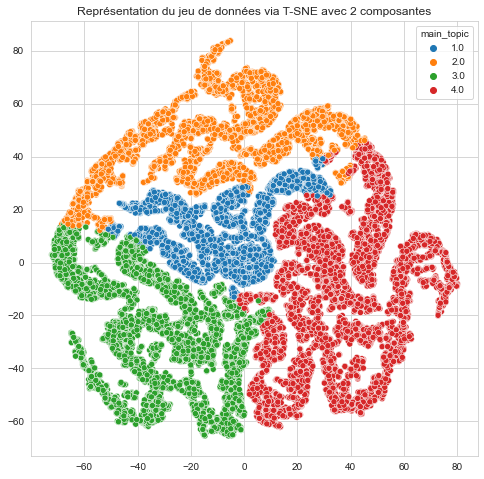

<IPython.core.display.Javascript object>

In [43]:
# Visualisation des données via T-SNE
plt.figure(figsize=(8, 8))
plt.title("Représentation du jeu de données via T-SNE avec 2 composantes")
sns.scatterplot(
    x=tsne_lda[:, 0],
    y=tsne_lda[:, 1],
    hue=df_topic_20.main_topic,
    palette=sns.color_palette(cols, 4),
)
plt.show()

Les topics sont assez bien répartis. On observe néanmoins quelques points de topics mélangés.

##### 3D

In [119]:
# main topic dans chaque texte
topic_num = np.argmax(best_lda_output, axis=1)

<IPython.core.display.Javascript object>

In [120]:
# array pour garder la bonne couleur de topic
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

<IPython.core.display.Javascript object>

In [121]:
%%time
# Réduction de dimension
tsne_model_3D = TSNE(n_components=3, random_state=0, angle=.99, init='pca')
tsne_lda_3D = tsne_model_3D.fit_transform(best_lda_output)

CPU times: user 12min 46s, sys: 27.9 s, total: 13min 14s
Wall time: 3min 27s


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


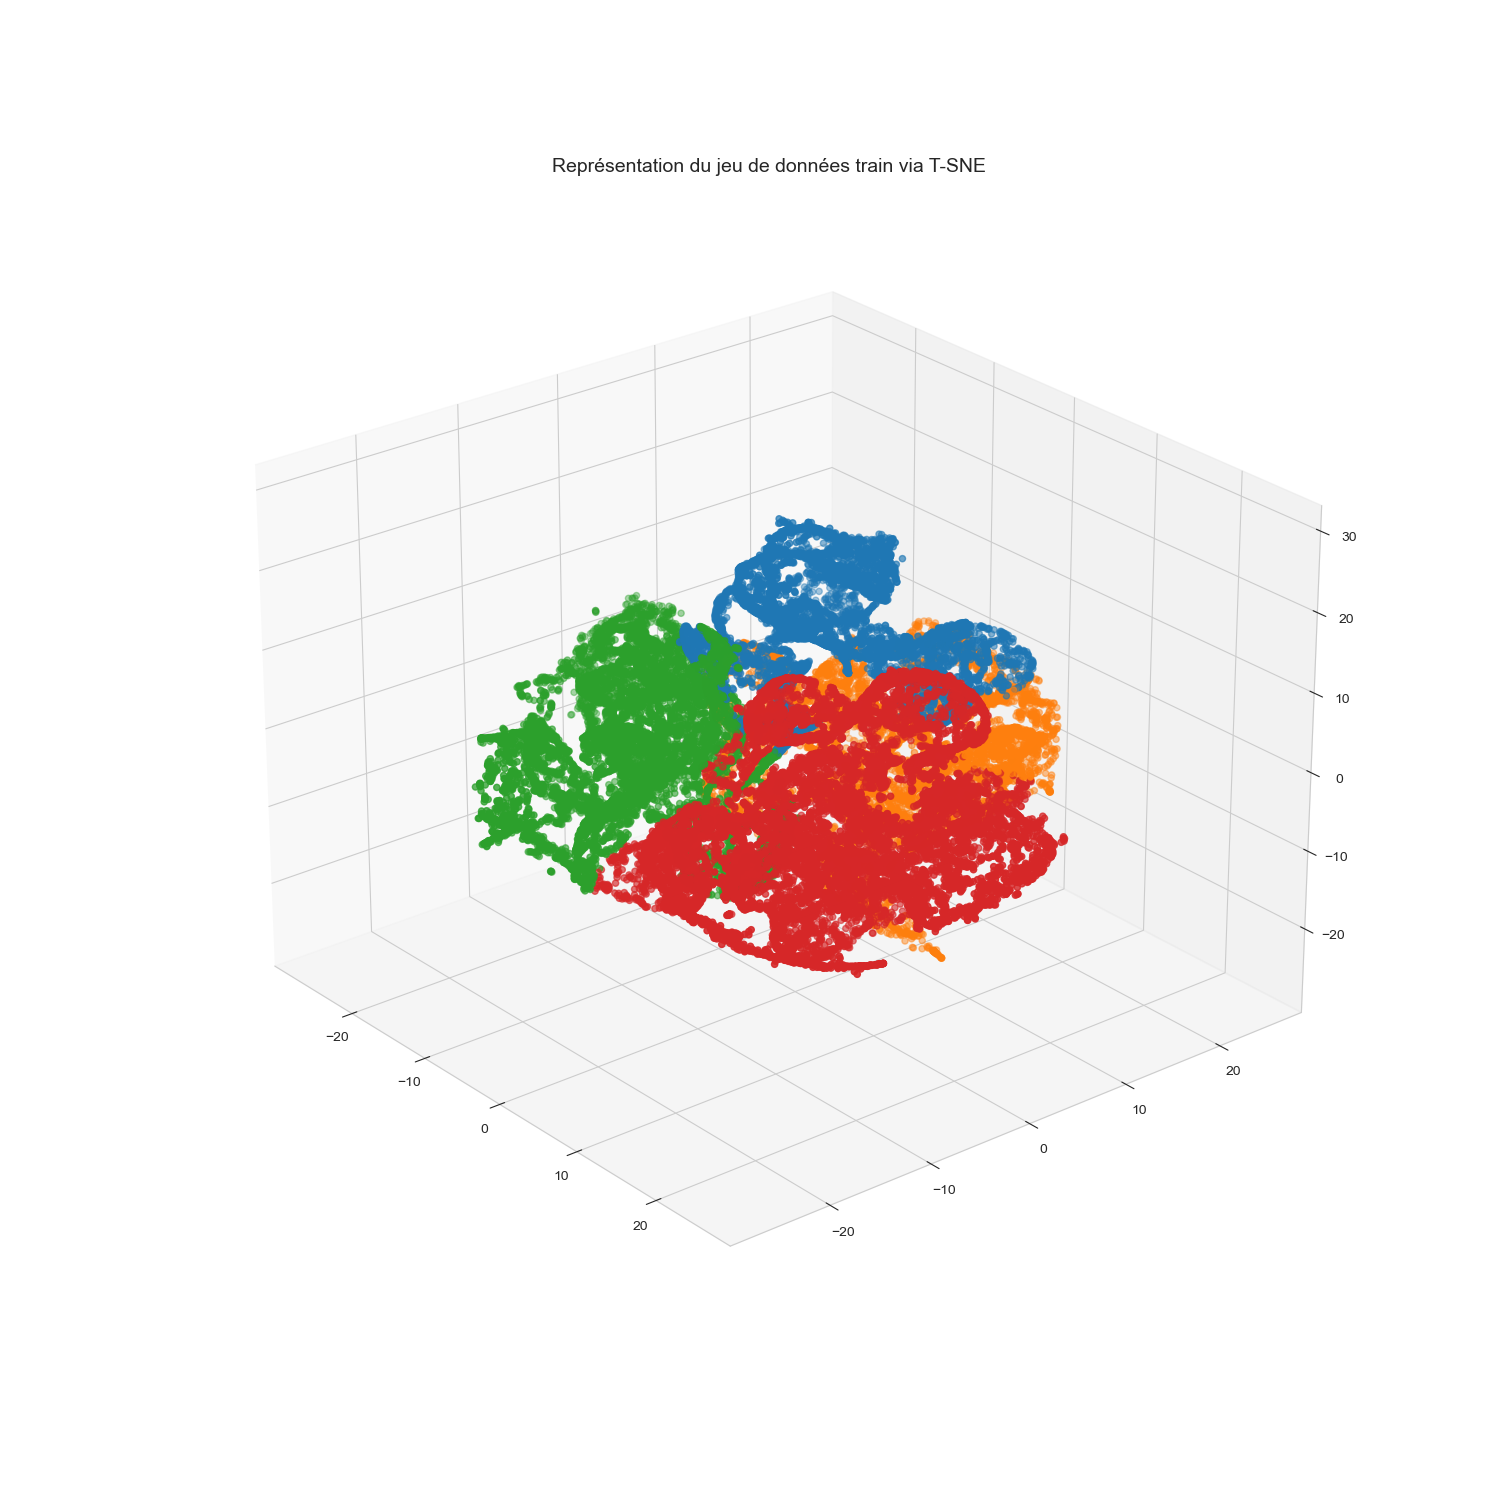

<IPython.core.display.Javascript object>

In [122]:
# Visualisation en 3D des données
%matplotlib notebook

plt.figure(figsize=(15, 15))
ax = plt.axes(projection="3d")
# Objet ax en 3D
ax.scatter(
    tsne_lda_3D[:, 0], tsne_lda_3D[:, 1], tsne_lda_3D[:, 2], color=mycolors[topic_num]
)
plt.title("Représentation du jeu de données train via T-SNE", size=14)

plt.show()

### 4.5. Prédictions des tags
On va effectuer la prédiction des tags sur le jeu de test pour comparer ultérieurement avec les modèles supervisés.

In [8]:
def predict_lda_tags(model, lemmed_text, dico_topic):

    """ Fonction pour prédire les tags d'un texte à partir d'un modèle lda
    
    - Arguments :
        - model : modèle qui génère les tags
        - lemmed_text : texte à traiter
        - dico_topic : dictionnaire contenant les topics et les mots dans le topic
        
    - Retourne :
        - la liste des tags associés au texte traité
    """

    # Récupérer le corpus sous forme d'une liste d'un
    # seul string
    corpus = [" ".join(lemmed_text)]

    # vectorization
    data_tfidf = vectorizer_tfidf.transform(corpus)

    # application du modèle
    model_output = model.transform(data_tfidf)

    # récupération du topic associé
    topic_most_pr = model_output[0].argmax()

    # récupération des tags associés
    tags = dico_topic[topic_most_pr]

    # filtrage sur tags présents dans lemmed_text
    tags = [tag for tag in tags if tag in lemmed_text]

    return tags

<IPython.core.display.Javascript object>

In [41]:
def df_with_topics_test(model, df, lemmed_text, dico_topic, name):

    """ Fonction pour récupérer dans un dataframe les tags générés par un model lda
    à partir d'un texte contenu dans un dataframe
        
    - Arguments :
        - model : modèle qui génère les tags
        - df : dataframe contenant le texte à traiter
        - lemmed_text : texte à traiter
        - dico_topic : dictionnaire contenant les topics et les mots dans le topic
        - name : nom du modèle 
    
    - Retourne :
        - un dataframe avec les tags générés par le model et le nombre de tags
        pour chaque texte du datafame
    """

    # Initialisation du dataframe
    df_topic = pd.DataFrame()
    
    # Récupération des tags prédits pour chaque ligne du dataframe 
    # donnée en entrée
    for i in range(0, df.shape[0]):
        tags = predict_lda_tags(model, lemmed_text[i], dico_topic)
        
        # On récupère également le nombre de tags prédits
        df_topic = df_topic.append(
            pd.Series([tags, int(len(tags))]), ignore_index=True,
        )

    df_topic.columns = [
        "{}_tags".format(name),
        "len_{}_tags".format(name),
    ]

    return df_topic

<IPython.core.display.Javascript object>

In [42]:
# Avec les 20 premiers mots
df_tag_lda_20_test = df_with_topics_test(
    best_lda_model, test_set, test_set.lemmed_text, dico_topic_lda, "LDA_20"
)
df_tag_lda_20_test

LDA_20_tags  len_LDA_20_tags
0                                                    []              0.0
1                                               [model]              1.0
2                    [error, service, app, api, access]              5.0
3     [python, line, error, command, import, module,...              7.0
4                                 [value, data, return]              3.0
...                                                 ...              ...
8895                                                 []              0.0
8896       [python, version, import, code, model, path]              6.0
8897  [request, module, http, response, client, func...             10.0
8898              [class, function, list, return, name]              5.0
8899                            [function, application]              2.0

[8900 rows x 2 columns]

<IPython.core.display.Javascript object>

In [43]:
# Avec les 50 premiers mots
df_tag_lda_50_test = df_with_topics_test(
    best_lda_model, test_set, test_set.lemmed_text, dico_topic_lda_50, "LDA_50"
)
df_tag_lda_50_test

LDA_50_tags  len_LDA_50_tags
0                                             [context]              1.0
1                                        [model, print]              2.0
2     [error, service, app, api, access, data, core,...             11.0
3     [python, line, error, command, import, module,...             10.0
4        [value, data, return, way, date, time, result]              7.0
...                                                 ...              ...
8895                                                 []              0.0
8896  [python, version, import, code, model, path, u...             10.0
8897  [request, module, http, response, client, func...             25.0
8898  [class, function, list, return, name, child, t...              8.0
8899                     [function, application, login]              3.0

[8900 rows x 2 columns]

<IPython.core.display.Javascript object>

### 4.6. Visualisation du jeu de données test via TSNE
#### 2D

In [48]:
# vectorization
test_tfidf = vectorizer_tfidf.transform(test_corpus)

# Récupération des données en sortie du modèle
test_lda_output = best_lda_model.transform(test_tfidf)

<IPython.core.display.Javascript object>

In [49]:
df_topic_test_lda_20, test_lda_output = df_output_topics(
    best_lda_model, test_tfidf, dico_topic_lda
)
df_topic_test_lda_20

main_topic  topic_perc  \
0            1.0      0.4875   
1            2.0      0.7699   
2            3.0      0.8690   
3            2.0      0.8325   
4            4.0      0.4950   
...          ...         ...   
8895         2.0      0.5971   
8896         2.0      0.7620   
8897         3.0      0.7070   
8898         4.0      0.7465   
8899         3.0      0.4801   

                                            topic_words  
0     [java, docker, flutter, android, com, version,...  
1     [file, python, package, version, line, error, ...  
2     [error, request, module, http, json, response,...  
3     [file, python, package, version, line, error, ...  
4     [value, data, class, color, button, view, comp...  
...                                                 ...  
8895  [file, python, package, version, line, error, ...  
8896  [file, python, package, version, line, error, ...  
8897  [error, request, module, http, json, response,...  
8898  [value, data, class, color, button, view, comp...  
8899  [error, request, module, http, json, response,...  

[8900 rows x 3 columns]

<IPython.core.display.Javascript object>

In [50]:
%%time
# Réduction de dimension
tsne_model = TSNE(n_components=2, random_state=0, angle=.99, init='pca')
tsne_lda_test = tsne_model.fit_transform(test_lda_output)

CPU times: user 2min 8s, sys: 9.27 s, total: 2min 17s
Wall time: 37.4 s


<IPython.core.display.Javascript object>

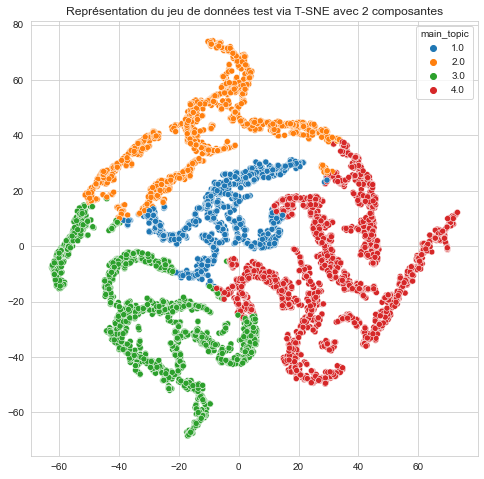

<IPython.core.display.Javascript object>

In [51]:
# Visualisation des données via T-SNE
plt.figure(figsize=(8, 8))
plt.title("Représentation du jeu de données test via T-SNE avec 2 composantes")
sns.scatterplot(
    x=tsne_lda_test[:, 0],
    y=tsne_lda_test[:, 1],
    hue=df_topic_test_lda_20.main_topic,
    palette=sns.color_palette(cols, 4),
)
plt.show()

On a globalement une bonne séparation spatiale.

#### 3D

In [123]:
# main topic dans chaque texte
topic_num_test = np.argmax(test_lda_output, axis=1)

<IPython.core.display.Javascript object>

In [124]:
%%time
# Réduction de dimension
tsne_model_3D_test = TSNE(n_components=3, random_state=0, angle=.99, init='pca')
tsne_lda_3D_test = tsne_model_3D_test.fit_transform(test_lda_output)

CPU times: user 2min 42s, sys: 8.27 s, total: 2min 50s
Wall time: 44.8 s


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


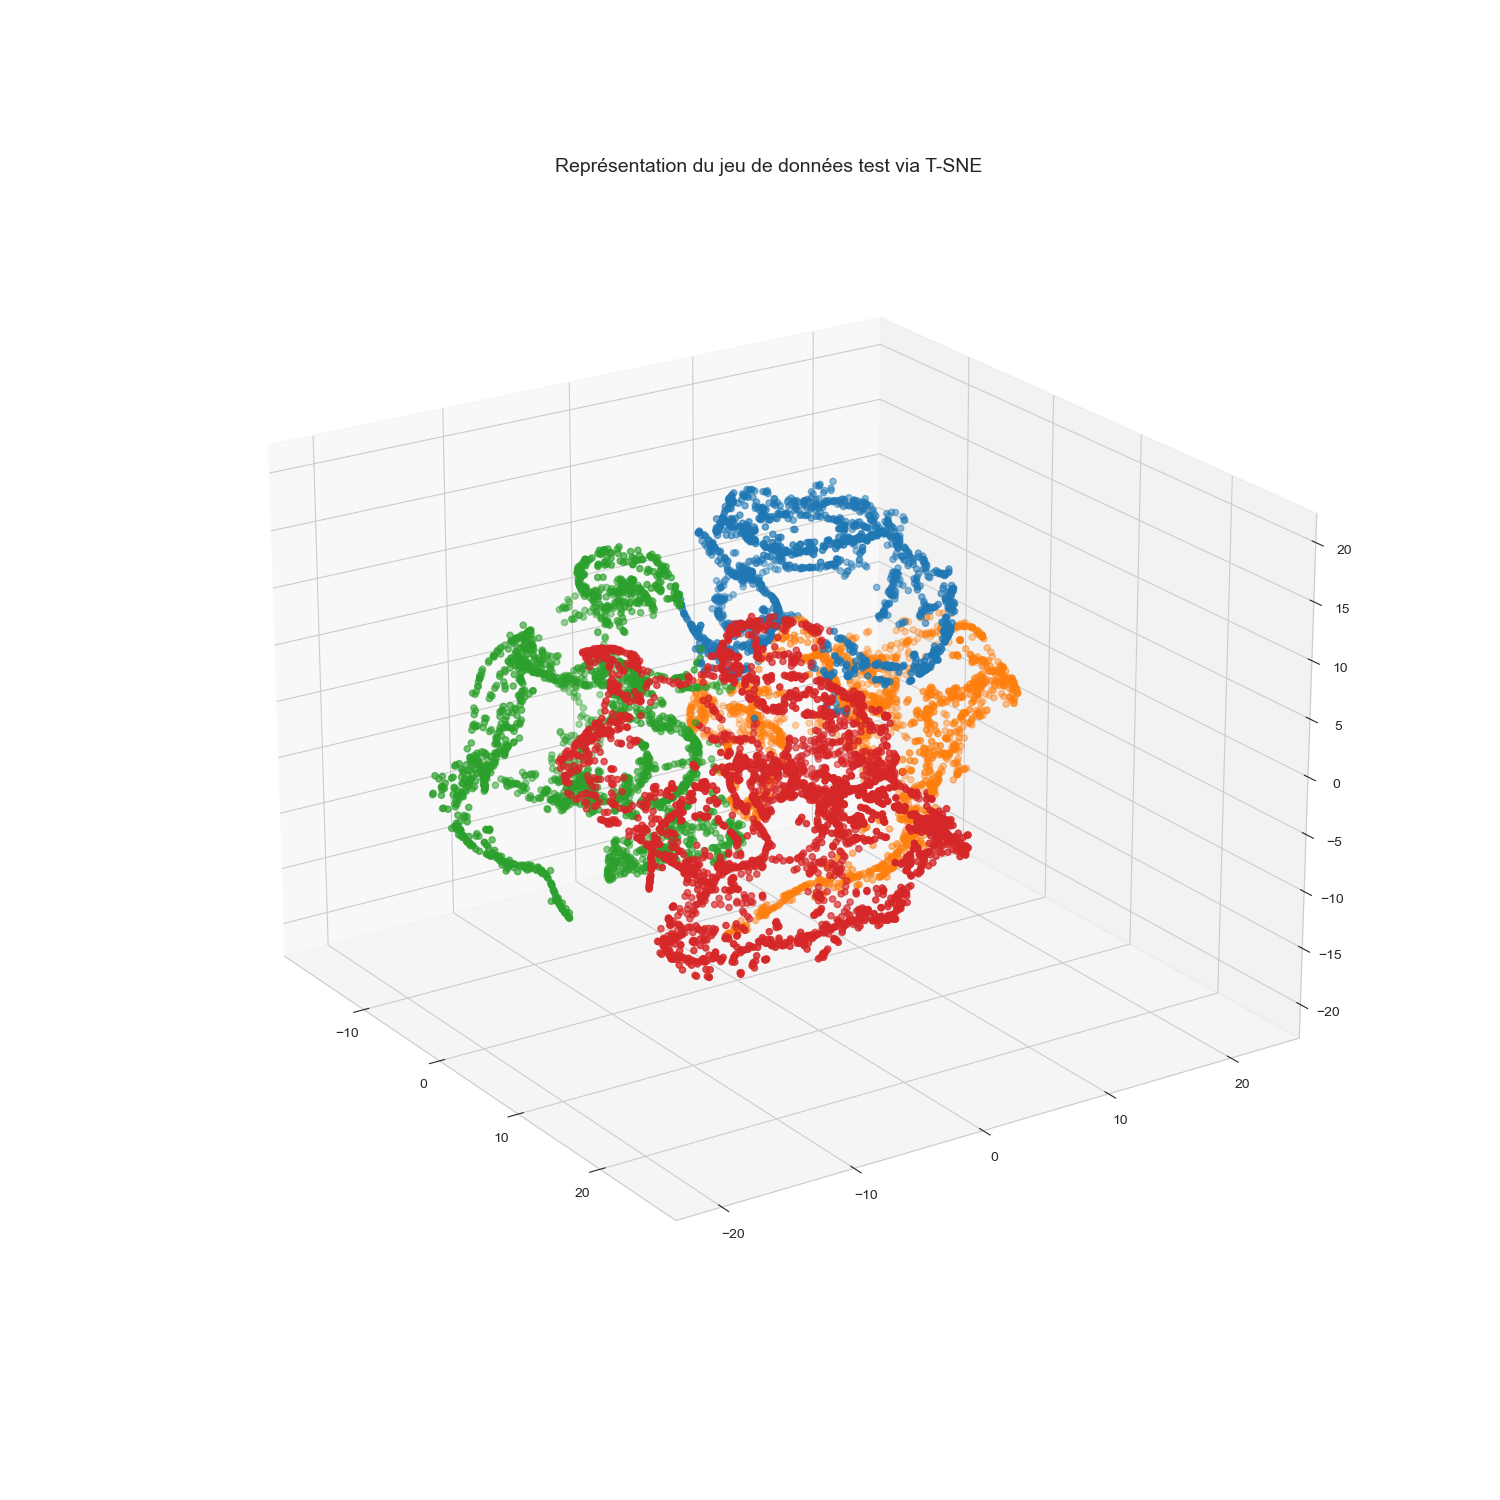

<IPython.core.display.Javascript object>

In [125]:
# Visualisation en 3D des données
#%matplotlib notebook

plt.figure(figsize=(15, 15))
ax = plt.axes(projection="3d")
# Objet ax en 3D
ax.scatter(
    tsne_lda_3D_test[:, 0],
    tsne_lda_3D_test[:, 1],
    tsne_lda_3D_test[:, 2],
    color=mycolors[topic_num_test],
)
plt.title("Représentation du jeu de données test via T-SNE", size=14)

plt.show()

## 5. Approche supervisée
On va maintenant utiliser une approche supervisée pour faire la prédiction de tags.

### 5.1. Suppression des doublons dans les tags
Suite au traitement de texte (suppression des chiffres et caractères spéciaux), certains tags apparaissent plusieurs fois, nous allons donc supprimer ces doublons.

In [52]:
# Liste pour stocker les labels uniques du jeu de train
label_train = []

# Suppression des doublons
for tag in train_set.tags_in_top200:
    label_train.append(set(tag))

# Affichage de la première ligne
label_train[0]

{'package'}

<IPython.core.display.Javascript object>

In [53]:
# Persistence of the label_train for MLFlow
filename_label_train = "./models/label_train2.joblib"
joblib.dump(label_train, filename_label_train)

['./models/label_train2.joblib']

<IPython.core.display.Javascript object>

In [54]:
# Liste pour stocker les labels uniques du jeu de test
label_test = []

# Suppression des doublons
for tag in test_set.tags_in_top200:
    label_test.append(set(tag))

# Affichage de la première ligne
label_test[0]

{'hook', 'react', 'reactjs'}

<IPython.core.display.Javascript object>

### 5.2. PCA
On va réduire le jeu de données en terme de variables (actuellement 509 variables) afin d'optimiser le temps d'entrainement des modèles. On va effectuer une réduction via l'analyse en composante principale (PCA en anglais).

In [55]:
# Transformation en array
train_corpus_tfidf_array = train_corpus_tfidf.toarray()

# Entrainement du modèle
pca = PCA(random_state=42)
pca.fit(train_corpus_tfidf_array)

PCA(random_state=42)

<IPython.core.display.Javascript object>

In [56]:
def display_scree_plot(pca):

    """ Fonction pour représenter visualiser l'éboulis des valeurs propres de la pca
        
    - Arguments :
        - pca : modèle pcq entrainé
    
    - Affiche :
        - un barplot pour chaque composante de la pcs
        - la somme cumulée de l'inertie en pourcentage 
        (= variance expliquée par la pca)
    """

    plt.figure(figsize=(12, 8))
    scree = pca.explained_variance_ratio_ * 100

    # Barplot pour chaque composante
    plt.bar(np.arange(len(scree)) + 1, scree)

    # Somme cumulée
    plt.plot(np.arange(len(scree)) + 1, scree.cumsum(), c="red", marker="o")

    plt.xlabel("rang de l'axe d'inertie", size=13)
    plt.ylabel("pourcentage d'inertie", size=13)
    plt.title("Eboulis des valeurs propres", size=14)
    plt.show(block=False)

<IPython.core.display.Javascript object>

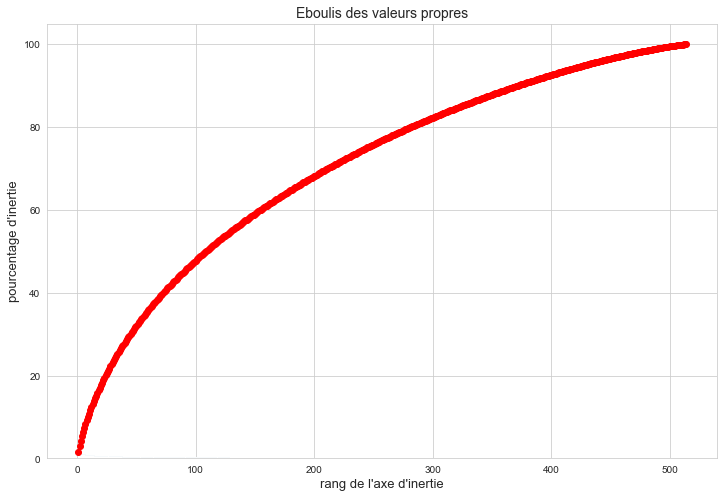

<IPython.core.display.Javascript object>

In [57]:
display_scree_plot(pca)

In [58]:
# Entrainement du modèle
pca = PCA(n_components=0.85, random_state=42)
pca.fit(train_corpus_tfidf_array)

# Application de la PCA
train_corpus_tfidf_tsfm = pca.transform(train_corpus_tfidf_array)

print("Taille de train_corpus_tfidf_tsfm : {}".format(train_corpus_tfidf_tsfm.shape))

Taille de train_corpus_tfidf_tsfm : (35598, 324)


<IPython.core.display.Javascript object>

On a réduit de presque 37% le nombre de variables.

### 5.3. Transformation des labels
On va encoder les labels, c'est-à-dire les tags (qui sont multiples), en array avec MultiLabelBinarizer, afin d'être utilisable par les algorithmes.

In [59]:
# Encodage des labels
mlb = MultiLabelBinarizer()
label_train_mlb = mlb.fit_transform(label_train)
label_test_mlb = mlb.transform(label_test)

print("Taille de label_train_mlb : {}".format(label_train_mlb.shape))
print("Taille de label_test_mlb : {}".format(label_test_mlb.shape))

Taille de label_train_mlb : (35598, 200)
Taille de label_test_mlb : (8900, 200)


<IPython.core.display.Javascript object>

In [60]:
# Persistence of the MultiLabelBinarizer
filename_mlb = "./models/mlb_model2.joblib"
joblib.dump(mlb, filename_mlb)

['./models/mlb_model2.joblib']

<IPython.core.display.Javascript object>

### 5.4. Mise en place de pipelines
On va mettre les différentes étapes dans un pipeline. Elle va regrouper les étapes de :
- Vectorisation
- Réduction de dimension
- Classification

Comme on a une sparse matrix en sortie de , on va utiliser TruncatedSVD à la place de PCA dans la pipeline. On va vérifier le nombre de composantes à prendre pour avoir une variance expliquée cumulée d'au moins 85%.
#### TruncatedSVD

In [62]:
svd = TruncatedSVD(n_components=510, random_state=42)
# On prend un nombre de components inférieur au nombre de variables

# On applique SVD sur le corpus vectorisé train_corpus_tfidf
train_SVD = svd.fit(train_corpus_tfidf)

<IPython.core.display.Javascript object>

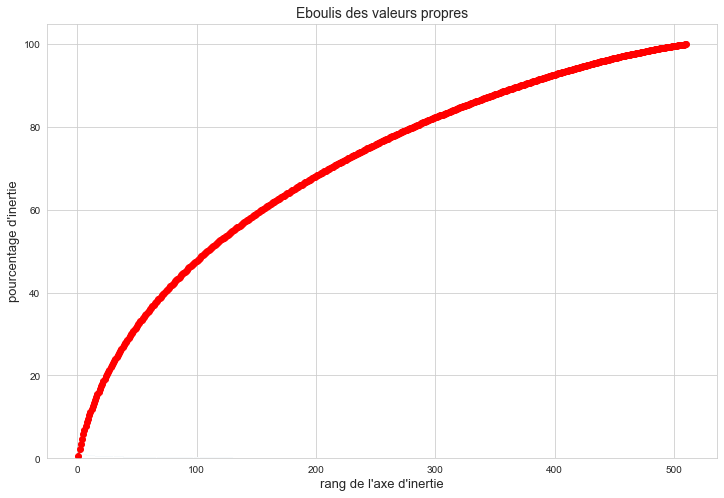

<IPython.core.display.Javascript object>

In [63]:
display_scree_plot(svd)

In [64]:
nb_comp = np.where(svd.explained_variance_ratio_.cumsum() >= 0.85)[0][0] + 1
nb_comp

325

<IPython.core.display.Javascript object>

On a une composante de plus avec TruncatedSVD par rapport à la PCA.

#### Contenu de la pipeline

La pipeline sera contenue dans la fonction de cross-validation par la suite. Voici son squelette, où 
- "name" sera le nom du classifieur (string)
- "model" sera le type de classifieur (objet).

In [ ]:
 pipeline = Pipeline(
        [
            ("tfidf", TfidfVectorizer(analyzer="word", vocabulary=list_words)),
            ("lsa", TruncatedSVD(n_components=nb_comp, random_state=42)),
            (name, model),
        ]
    )

### 5.5. Modèles testés
On va tester différents modèles de classification via une cross-validation :
- DummyClassifier,
- KNN
- SVM
- RandomForest
- GradBoosting (finalement non testé car trop long)

In [65]:
def cross_val(model, name, X_train, y_train):

    """ Fonction pour effectuer une cross-validation sur un modèle
    et retourne les scores du modèle dans un dataframe
        
    - Arguments :
        - model : modèle testé
        - name : nom du modèle (string)
        - X_train : données d'entrées
        - y_train : labels target
    
    - Retourne :
        - un dataframe avec les scores associés au modèle
    """

    pipeline = Pipeline(
        [
            ("tfidf", TfidfVectorizer(analyzer="word", vocabulary=list_words)),
            ("lsa", TruncatedSVD(n_components=nb_comp, random_state=42)),
            (name, model),
        ]
    )

    # Cross validation
    scores = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=5,
        scoring=[
            "accuracy",
            "precision_micro",
            "precision_macro",
            "recall_micro",
            "recall_macro",
            "f1_micro",
            "f1_macro",
        ],
    )

    # Récupération des scores lors de la cross-validation et on prend la moyenne
    accuracy = scores["test_accuracy"].mean()
    precision_micro = scores["test_precision_micro"].mean()
    precision_macro = scores["test_precision_macro"].mean()
    recall_micro = scores["test_recall_micro"].mean()
    recall_macro = scores["test_recall_macro"].mean()
    f1_micro = scores["test_f1_micro"].mean()
    f1_macro = scores["test_f1_macro"].mean()

    # Dataframe pour stocker les résultats
    df_model = pd.DataFrame(
        [
            [
                name,
                accuracy,
                precision_micro,
                precision_macro,
                recall_micro,
                recall_macro,
                f1_micro,
                f1_macro,
            ]
        ],
        columns=[
            "modele",
            "accuracy",
            "precision_micro",
            "precision_macro",
            "recall_micro",
            "recall_macro",
            "f1_micro",
            "f1_macro",
        ],
    )
    df_model = df_model.set_index("modele")

    return df_model

<IPython.core.display.Javascript object>

In [66]:
%%time
dummy_clf = DummyClassifier(strategy = 'uniform')
# uniform = generates predictions uniformly at random from the list of unique classes 
# observed in y, i.e. each class has equal probability
df_dummy_clf = cross_val(dummy_clf, "Dummy", train_corpus, label_train_mlb)
df_dummy_clf

CPU times: user 59.2 s, sys: 7.75 s, total: 1min 6s
Wall time: 37.1 s


accuracy  precision_micro  precision_macro  recall_micro  \
modele                                                             
Dummy        0.0         0.013115         0.013119      0.498786   

        recall_macro  f1_micro  f1_macro  
modele                                    
Dummy       0.496297  0.025558  0.024441

<IPython.core.display.Javascript object>

In [67]:
%%time
knn_clf = KNeighborsClassifier()
df_knn_clf = cross_val(knn_clf, "KNN", train_corpus, label_train_mlb)

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/met

CPU times: user 4min 31s, sys: 18.1 s, total: 4min 49s
Wall time: 3min 58s


<IPython.core.display.Javascript object>

In [68]:
%%time
svm_clf = OneVsRestClassifier(LinearSVC(), n_jobs=-1)
df_svm_clf = cross_val(svm_clf, "SVM", train_corpus, label_train_mlb)

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/met

CPU times: user 1min 6s, sys: 8.57 s, total: 1min 14s
Wall time: 3min 48s


<IPython.core.display.Javascript object>

In [80]:
%%time
rmf_clf = RandomForestClassifier(n_jobs=-1)
df_rmf_clf = cross_val(rmf_clf, "Random Forest", train_corpus, label_train_mlb)

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarnin

CPU times: user 3min 53s, sys: 44min 46s, total: 48min 40s
Wall time: 48min 35s


<IPython.core.display.Javascript object>

In [129]:
# Interrompu car trop long (RAS après 2h de lancement)
%%time
grad_boost_clf = OneVsRestClassifier(GradientBoostingClassifier())
df_grad_boost_clf = cross_val(grad_boost_clf, "Gradient Boosting", train_corpus, label_train_mlb)
df_grad_boost_clf

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [82]:
df_result = pd.concat([df_dummy_clf, df_knn_clf, df_svm_clf, df_rmf_clf], axis=0)
df_result

accuracy  precision_micro  precision_macro  recall_micro  \
modele                                                                    
Dummy          0.000000         0.013115         0.013119      0.498786   
KNN            0.100483         0.688424         0.530721      0.273560   
SVM            0.147256         0.800425         0.562547      0.367456   
Random Forest  0.048851         0.888180         0.285981      0.115611   

               recall_macro  f1_micro  f1_macro  
modele                                           
Dummy              0.496297  0.025558  0.024441  
KNN                0.178338  0.391530  0.243906  
SVM                0.222611  0.503668  0.289545  
Random Forest      0.038169  0.204583  0.060451

<IPython.core.display.Javascript object>

Le Dummy a le meilleure recall (taux de vrais positifs), par contre les autres scores sont très mauvais.

La Random Forest a la precision_micro la plus élevée, mais les autres scores sont mauvais. Par ailleurs, elle a mis beaucoup plus de temps que KNN ou SVM (48 min vs 4 min !), par conséquent, on va éliminer ce modèle.

Le SVM présente des meilleurs scores par rapport au KNN, on va donc retenir ce modèle.
### 5.6. Optimisation SVM
On va optimiser le modèle par un GridSearch manuel (avec un cross validation) car le GridSearchCV de sklearn n'a pas marché.

In [70]:
# Création de la pipeline avec SVM
pipeline_SVM = Pipeline(
    [
        ("tfidf", TfidfVectorizer(analyzer="word", vocabulary=list_words)),
        ("lsa", TruncatedSVD(n_components=nb_comp, random_state=42)),
        ("SVM", OneVsRestClassifier(LinearSVC(), n_jobs=-1)),
    ]
)

# Liste des scores
scores = [
    "accuracy",
    "precision_micro",
    "precision_macro",
    "recall_micro",
    "recall_macro",
    "f1_micro",
    "f1_macro",
]

<IPython.core.display.Javascript object>

In [71]:
%%time

# Dictionnaire d'hyperparamètres
hyper_params_svm = {"SVM__estimator__C": np.logspace(-3, 1, 5)}

# initialiser la validation croisée
grid_svm = GridSearchCV(pipeline_SVM, param_grid=hyper_params_svm, scoring = scores, refit = "accuracy")

# entrainement du modèle
grid_svm.fit(train_corpus)

# Meilleur modèle
best_svm_model = grid_svm.best_estimator_

# Affichage des meilleurs paramètres
print("Best paramètres pour SVM : ")
for params, val in grid_svm.best_params_.items():
    print(" - ", params, ":", val)

# Récupération du meilleur score accuracy 
accuracy = grid_svm.best_score_

# Récupération des scores lors de la cross-validation 
precision_micro = grid.cv_results_["mean_test_precision_micro"][grid_svm.best_index_]
precision_macro = grid.cv_results_["mean_test_precision_macro"][grid_svm.best_index_]
recall_micro = grid.cv_results_["mean_test_recall_micro"][grid_svm.best_index_]
recall_macro = grid.cv_results_["mean_test_recall_macro"][grid_svm.best_index_]
f1_micro = grid.cv_results_["mean_test_f1_micro"][grid_svm.best_index_]
f1_macro = grid.cv_results_["mean_test_f1_macro"][grid_svm.best_index_]

# Récupération du temps d'entrainement du modèle
mean_time = grid.cv_results_["mean_fit_time"][grid_svm.best_index_]

# Affichage des résultats
print("Résultats pour SVM sur le jeu de train :")
print(" - accuracy :", accuracy)
print(
    " - precision \n    > micro : {:.4f}\n    > macro: {:.4f}\n".format(
        precision_micro, precision_macro
    )
)
print(
    " - recall \n    > micro : {:.4f}\n    > macro: {:.4f}\n".format(
        recall_micro, recall_macro
    )
)
print(" - f1 \n    > micro : {:.4f}\n    > macro: {:.4f}\n".format(f1_micro, f1_macro))
print("- Temps d'entrainement : {:.4f} s \n".format(mean_time))

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 596, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py", line 274, in fit
    Y = self.label_binarizer_.fit_transform(y)
  File "/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py", line 321, in fit_transform
    return self.fit(y).transform(y)
  File "/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py", line

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 596, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py", line 274, in fit
    Y = self.label_binarizer_.fit_transform(y)
  File "/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py", line 321, in fit_transform
    return self.fit(y).transform(y)
  File "/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py", line

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 596, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py", line 274, in fit
    Y = self.label_binarizer_.fit_transform(y)
  File "/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py", line 321, in fit_transform
    return self.fit(y).transform(y)
  File "/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py", line

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 596, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py", line 274, in fit
    Y = self.label_binarizer_.fit_transform(y)
  File "/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py", line 321, in fit_transform
    return self.fit(y).transform(y)
  File "/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py", line

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 596, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py", line 274, in fit
    Y = self.label_binarizer_.fit_transform(y)
  File "/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py", line 321, in fit_transform
    return self.fit(y).transform(y)
  File "/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py", line

ValueError: Expected array-like (array or non-string sequence), got None

<IPython.core.display.Javascript object>

Nous allons créer manuellement la fonction de GridSearch.

In [72]:
def svm_grid(name, C, X_train, y_train):

    """ Fonction pour effectuer une cross-validation sur un modèle
    de SVM pour différentes valeurs de C (paramètre de régularisation) 
    et retourner les scores du modèle dans un dataframe
        
    - Arguments :
        - name : nom du modèle
        - C : valeurs de l'hyperparamètre
        - X_train : données d'entrées
        - y_train : labels target
    
    - Retourne :
        - un dataframe avec les scores associés au modèle et 
        la valeur de l'hyperparamètre
    """

    pipeline = Pipeline(
        [
            ("tfidf", TfidfVectorizer(analyzer="word", vocabulary=list_words)),
            ("lsa", TruncatedSVD(n_components=nb_comp, random_state=42)),
            ("SVM", OneVsRestClassifier(LinearSVC(C=C), n_jobs=-1)),
        ]
    )
    # Cross validation
    scores = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=5,
        scoring=[
            "accuracy",
            "precision_micro",
            "precision_macro",
            "recall_micro",
            "recall_macro",
            "f1_micro",
            "f1_macro",
        ],
    )

    # Récupération des scores lors de la cross-validation et on prend la moyenne
    accuracy = scores["test_accuracy"].mean()
    precision_micro = scores["test_precision_micro"].mean()
    precision_macro = scores["test_precision_macro"].mean()
    recall_micro = scores["test_recall_micro"].mean()
    recall_macro = scores["test_recall_macro"].mean()
    f1_micro = scores["test_f1_micro"].mean()
    f1_macro = scores["test_f1_macro"].mean()

    # Dataframe pour stocker les résultats
    df_model = pd.DataFrame(
        [
            [
                name,
                C,
                accuracy,
                precision_micro,
                precision_macro,
                recall_micro,
                recall_macro,
                f1_micro,
                f1_macro,
            ]
        ],
        columns=[
            "modele",
            "C",
            "accuracy",
            "precision_micro",
            "precision_macro",
            "recall_micro",
            "recall_macro",
            "f1_micro",
            "f1_macro",
        ],
    )
    df_model = df_model.set_index("modele")

    return df_model

<IPython.core.display.Javascript object>

In [74]:
%%time
df_result_svm = pd.DataFrame()
for c in np.logspace(-3, 1, 5):
    df_result_svm = pd.concat(
        [df_result_svm, svm_grid("SVM", c, train_corpus, label_train_mlb)], axis=0
    )
df_result_svm

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/met

CPU times: user 5min 29s, sys: 45.1 s, total: 6min 14s
Wall time: 23min 22s


C  accuracy  precision_micro  precision_macro  recall_micro  \
modele                                                                     
SVM      0.001  0.003849         0.947473         0.022432      0.006432   
SVM      0.010  0.063318         0.873285         0.222556      0.154423   
SVM      0.100  0.122957         0.823625         0.389774      0.304882   
SVM      1.000  0.147256         0.800425         0.562547      0.367456   
SVM     10.000  0.149812         0.768308         0.580942      0.393184   

        recall_macro  f1_micro  f1_macro  
modele                                    
SVM         0.000767  0.012777  0.001449  
SVM         0.047014  0.262435  0.070722  
SVM         0.150677  0.445006  0.200391  
SVM         0.222611  0.503668  0.289545  
SVM         0.273118  0.520163  0.346622

<IPython.core.display.Javascript object>

Entre C = 1 et C = 10, on a une faible amélioration de l'accuracy, on diminue la precision micro, on améliore le recall_micro, ainsi que les grandeurs macro.

In [75]:
df_result_svm = pd.DataFrame()
for c in np.logspace(2, 4, 3):
    df_result_svm = pd.concat(
        [df_result_svm, svm_grid("SVM", c, train_corpus, label_train_mlb)], axis=0
    )
df_result_svm

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anacond

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anacond

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anacond

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anacond

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anacond

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anacond

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anacond

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anacond

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anacond

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anacond

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of it

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anacond

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anacond

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C  accuracy  precision_micro  precision_macro  recall_micro  \
modele                                                                      
SVM       100.0  0.136693         0.710005         0.505931      0.402352   
SVM      1000.0  0.078600         0.502503         0.433007      0.418638   
SVM     10000.0  0.053654         0.429445         0.409490      0.416899   

        recall_macro  f1_micro  f1_macro  
modele                                    
SVM         0.290675  0.513626  0.343878  
SVM         0.304675  0.456148  0.312156  
SVM         0.311760  0.420762  0.304541

<IPython.core.display.Javascript object>

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

Avec 100, 1000 et 10000, il faut augmenter le nombre d'itérations car ça ne converge pas. Par ailleurs, cela prend beaucoup de temps. On a interrompu le run.

In [164]:
%%time
df_result_svm2 = pd.DataFrame()
for c in [15, 20, 25, 30, 40, 50]:
    df_result_svm2 = pd.concat(
        [df_result_svm2, svm_grid("SVM", c, train_corpus, label_train_mlb)], axis=0
    )
df_result_svm2

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/met

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/s

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/met

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/met

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anacond

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CPU times: user 6min 41s, sys: 43.9 s, total: 7min 25s
Wall time: 1h 43min 12s


C  accuracy  precision_micro  precision_macro  recall_micro  \
modele                                                                 
SVM     15  0.147508         0.760714         0.561725      0.395061   
SVM     20  0.146638         0.755131         0.556989      0.396418   
SVM     25  0.145739         0.749638         0.548795      0.397316   
SVM     30  0.144980         0.745057         0.543106      0.397744   
SVM     40  0.143716         0.737949         0.533797      0.398791   
SVM     50  0.142677         0.732187         0.526781      0.399518   

        recall_macro  f1_micro  f1_macro  
modele                                    
SVM         0.276472  0.520034  0.347267  
SVM         0.279876  0.519895  0.349028  
SVM         0.281974  0.519352  0.349142  
SVM         0.282991  0.518612  0.348451  
SVM         0.285213  0.517763  0.347943  
SVM         0.287101  0.516947  0.347525

<IPython.core.display.Javascript object>

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

Au delà de C = 10, il y a des problèmes de convergence. Par ailleurs, on constate que l'accuracy diminue, ainsi que la précision et le score de f1_micro, alors que les autres métriques augmentent très très légèrement.

On va donc garder dans un premier temps les modèles pour C = 1 et C = 10. On les comparera par la suite.

In [76]:
# Déclaration de la pipeline
pipeline_SVM_1 = Pipeline(
    [
        ("tfidf", TfidfVectorizer(analyzer="word", vocabulary=list_words)),
        ("lsa", TruncatedSVD(n_components=nb_comp, random_state=42)),
        ("SVM", OneVsRestClassifier(LinearSVC(C=1), n_jobs=-1)),
    ]
)

# Entrainement du modèle
pipeline_SVM_1.fit(train_corpus, label_train_mlb)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(vocabulary=['error', 'file', 'java', 'name',
                                             'class', 'data', 'import', 'com',
                                             'version', 'code', 'value',
                                             'module', 'http', 'user', 'app',
                                             'package', 'function', 'return',
                                             'type', 'test', 'image', 'org',
                                             'use', 'python', 'line', 'project',
                                             'core', 'service', 'log',
                                             'application', ...])),
                ('lsa', TruncatedSVD(n_components=325, random_state=42)),
                ('SVM',
                 OneVsRestClassifier(estimator=LinearSVC(C=1), n_jobs=-1))])

<IPython.core.display.Javascript object>

In [77]:
# Déclaration de la pipeline
pipeline_SVM_10 = Pipeline(
    [
        ("tfidf", TfidfVectorizer(analyzer="word", vocabulary=list_words)),
        ("lsa", TruncatedSVD(n_components=nb_comp, random_state=42)),
        ("SVM", OneVsRestClassifier(LinearSVC(C=10), n_jobs=-1)),
    ]
)

# Entrainement du modèle
pipeline_SVM_10.fit(train_corpus, label_train_mlb)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(vocabulary=['error', 'file', 'java', 'name',
                                             'class', 'data', 'import', 'com',
                                             'version', 'code', 'value',
                                             'module', 'http', 'user', 'app',
                                             'package', 'function', 'return',
                                             'type', 'test', 'image', 'org',
                                             'use', 'python', 'line', 'project',
                                             'core', 'service', 'log',
                                             'application', ...])),
                ('lsa', TruncatedSVD(n_components=325, random_state=42)),
                ('SVM',
                 OneVsRestClassifier(estimator=LinearSVC(C=10), n_jobs=-1))])

<IPython.core.display.Javascript object>

In [78]:
# Persistence
filename_pipeline_SVM_1 = "./models/pipeline_SVM_1_2.joblib"
joblib.dump(pipeline_SVM_1, filename_pipeline_SVM_1)

['./models/pipeline_SVM_1_2.joblib']

<IPython.core.display.Javascript object>

In [79]:
# Persistence
filename_pipeline_SVM_10 = "./models/pipeline_SVM_10_2.joblib"
joblib.dump(pipeline_SVM_10, filename_pipeline_SVM_10)

['./models/pipeline_SVM_10_2.joblib']

<IPython.core.display.Javascript object>

### 5.7. Scores sur le jeu de test
On va regarder ce que donnent les scores sur le jeu de test.

In [83]:
def get_scores(model, name, X_test, y_test):

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision_micro = precision_score(y_test, y_pred, average="micro", zero_division=0)
    precision_macro = precision_score(y_test, y_pred, average="macro", zero_division=0)
    recall_micro = recall_score(y_test, y_pred, average="micro")
    recall_macro = recall_score(y_test, y_pred, average="macro")
    f1_micro = f1_score(y_test, y_pred, average="micro")
    f1_macro = f1_score(y_test, y_pred, average="macro")
    print("Résultats pour {} sur le jeu de test :".format(name))
    print(" - accuracy :", accuracy)
    print(
        " - precision \n    > micro : {:.4f}\n    > macro: {:.4f}\n".format(
            precision_micro, precision_macro
        )
    )
    print(
        " - recall \n    > micro : {:.4f}\n    > macro: {:.4f}\n".format(
            recall_micro, recall_macro
        )
    )
    print(
        " - f1 \n    > micro : {:.4f}\n    > macro: {:.4f}\n".format(f1_micro, f1_macro)
    )

<IPython.core.display.Javascript object>

In [84]:
get_scores(pipeline_SVM_1, "SVM_1", test_corpus, label_test_mlb)

Résultats pour SVM_1 sur le jeu de test :
 - accuracy : 0.14168539325842697
 - precision 
    > micro : 0.8018
    > macro: 0.5797

 - recall 
    > micro : 0.3664
    > macro: 0.2269

 - f1 
    > micro : 0.5030
    > macro: 0.2944



<IPython.core.display.Javascript object>

In [85]:
get_scores(
    pipeline_SVM_10, "SVM_10", test_corpus, label_test_mlb,
)

Résultats pour SVM_10 sur le jeu de test :
 - accuracy : 0.1456179775280899
 - precision 
    > micro : 0.7818
    > macro: 0.6063

 - recall 
    > micro : 0.3884
    > macro: 0.2706

 - f1 
    > micro : 0.5190
    > macro: 0.3442



<IPython.core.display.Javascript object>

Pour SVM_1, par rapport aux scores sur le jeu de train, on a :
- une accuracy plus faible,
- des scores macro légèrement plus élevés,
- des scores micro légèrement plus faibles sauf pour la précision

Pour SVM_10, par rapport aux scores sur le jeu de train, on a tous les scores sont légèrement plus faibles, sauf pour la précision.

Là encore, on a une meilleure accuracy avec SVM_10.

### 5.8. Prédictions des tags

On va définir une fonction pour prédire les tags issus d'un texte à partir d'un modèle. On va aussi filtrer ces tags prédits : ils doivent être contenus dans le texte (mis sous forme de lems).

In [7]:
def predict_tags(model, lemmed_text):

    """ Fonction pour afficher la liste des tags prédits par le
    modèle
    
    - Arguments :
        - model : modèle à utiliser pour la prédiction
        - lemmed_text : texte dont il faut prédire les tags
    
    - Retourne:
         - la liste des tags, en filtrant sur les mots présents
        dans le texte
    """

    # Application du modèle
    text_model = model.predict(lemmed_text)

    # Récupération des labels
    text_tags = mlb.inverse_transform(text_model)

    # Liste des tags
    pred_tags_list = list(
        {tag for tag_list in text_tags for tag in tag_list if (len(tag_list) != 0)}
    )

    # Filtrage sur les mots présents dans le lemmed_text
    pred_tags_list = [tag for tag in pred_tags_list if tag in lemmed_text]

    return pred_tags_list

<IPython.core.display.Javascript object>

Afin de comparer les tags prédits et les tags renseignés par les utilisateurs, on créée une fonction de comparaison.

In [87]:
def origin_vs_predict_tags(raw_text, lemmed_tags, lemmed_text, model):

    """ Fonction pour comparer les tags d'origine avec ceux
    prédits par un modèle
    
    - Arguments :
        - raw_text : le texte d'origine
        - lemmed_tags : tags mis par les utilisateurs
        - lemmed_text : texte sous forme de lemmes
        - model : modèle à utiliser pour prédire les tags
    
    - Affiche :
        - texte d'origine
        - liste des tags mis par les utilisateurs
        - liste des tags prédits
    """

    pred_tags_list = predict_tags(model, lemmed_text)
    print(">>> Texte original : \n {} \n".format(raw_text))
    print(
        ">>> Liste des lemmed tags indiqués par les utilisateurs : {} \n".format(
            lemmed_tags
        )
    )
    print(">>> Liste des tags prédits par le modèle: {}".format(pred_tags_list))

<IPython.core.display.Javascript object>

In [88]:
origin_vs_predict_tags(
    train_set.loc[52, "raw_text"],
    train_set.loc[52, "lemmed_tags"],
    train_set.loc[52, "lemmed_text"],
    pipeline_SVM_1,
)

>>> Texte original : 
 Error "Installation failed, reverting ./composer.json to its original content." I wanna connect my Laravel project to parse-server. And I follow the step in https://github.com/LaravelParse/Laravel-Parse
when I run this command: 
composer require laravel-parse/parse

Then I got an error:

Installation failed, reverting ./composer.json to its original content.

I also tried to add in composer.json file: 
"require": {
    "laravel-parse/parse": "^3.0"
} 

My Laravel version is: 5.7.18 
 

>>> Liste des lemmed tags indiqués par les utilisateurs : ['laravel', 'laravel'] 

>>> Liste des tags prédits par le modèle: ['json', 'laravel', 'github']


<IPython.core.display.Javascript object>

In [89]:
origin_vs_predict_tags(
    train_set.loc[52, "raw_text"],
    train_set.loc[52, "lemmed_tags"],
    train_set.loc[52, "lemmed_text"],
    pipeline_SVM_10,
)

>>> Texte original : 
 Error "Installation failed, reverting ./composer.json to its original content." I wanna connect my Laravel project to parse-server. And I follow the step in https://github.com/LaravelParse/Laravel-Parse
when I run this command: 
composer require laravel-parse/parse

Then I got an error:

Installation failed, reverting ./composer.json to its original content.

I also tried to add in composer.json file: 
"require": {
    "laravel-parse/parse": "^3.0"
} 

My Laravel version is: 5.7.18 
 

>>> Liste des lemmed tags indiqués par les utilisateurs : ['laravel', 'laravel'] 

>>> Liste des tags prédits par le modèle: ['json', 'laravel', 'github', 'http']


<IPython.core.display.Javascript object>

Afin de pouvoir faire des études comparatives quantitatives, on va stocker dans un dataframe les tags générés par le modèle supervisé.

In [39]:
def df_with_topics_test_SVM(model, df, lemmed_text, name_SVM):

    """ Fonction pour récupérer dans un dataframe les tags générés par un model lda
    à partir d'un texte contenu dans un dataframe
        
    - Arguments :
        - model : modèle qui génère les tags
        - df : dataframe contenant le texte à traiter
        - lemmed_text : texte à traiter
    
    - Retourne :
        - un dataframe avec les tags générés par le model et le nombre de tags
        pour chaque texte du datafame
    """

    # Initialisation du dataframe
    df_topic = pd.DataFrame()

    for i in range(0, df.shape[0]):
        tags = predict_tags(model, lemmed_text[i])

        df_topic = df_topic.append(
            pd.Series([tags, int(len(tags))]), ignore_index=True,
        )

    df_topic.columns = [
        "{}_tags".format(name_SVM),
        "len_{}_tags".format(name_SVM),
    ]

    return df_topic

<IPython.core.display.Javascript object>

In [40]:
df_svm_1_tag = df_with_topics_test_SVM(
    pipeline_SVM_1, test_set, test_set.lemmed_text, "SVM_1"
)
df_svm_1_tag

SVM_1_tags  len_SVM_1_tags
0                                                [hook]             1.0
1                                                    []             0.0
2           [azure, api, idea, net, sql, storage, core]             7.0
3                                         [cli, python]             2.0
4                                   [server, api, core]             3.0
...                                                 ...             ...
8895                                                 []             0.0
8896                                     [code, python]             2.0
8897  [code, storage, script, function, api, bootstr...            12.0
8898                    [list, idea, function, laravel]             4.0
8899              [window, swift, action, function, io]             5.0

[8900 rows x 2 columns]

<IPython.core.display.Javascript object>

In [44]:
df_svm_10_tag = df_with_topics_test_SVM(
    pipeline_SVM_10, test_set, test_set.lemmed_text, "SVM_10"
)

<IPython.core.display.Javascript object>

## 6. Comparaison supervisé/non supervisé
### 6.1. Visualisation sur quelques posts du jeu de train

In [6]:
def supervis_vs_unsupervis_tags(
    raw_text, lemmed_tags, lemmed_text, unsupervised_model, dico_topic, supervised_model
):

    """ Fonction pour comparer les tags prédits par les modèles supervisés
    et non supervisés vs les true tags pour un texte
    
    Arguments :
        - raw_text : texte brut d'origine
        - lemmed_tags : tags d'origine sous forme de lems tags (liste)
        - lemmed_text : texte d'origine sous forme de lems (liste)
        - unsupervised_model : modèle non supervisé
        - supervised_model : modèle supervisé
    
    Affiche :
        - le texte d'origine
        - liste des lemmed tags indiqués par les utilisateurs
        - liste des tags prédits par le modèle supervisé
        - liste des tags prédits par le modèle non-supervisé
    """

    pred_tags_list = predict_tags(supervised_model, lemmed_text)
    pred_tags_lda = predict_lda_tags(unsupervised_model, lemmed_text, dico_topic)
    print(">>> Texte original : \n {} \n".format(raw_text))
    print(
        ">>> Liste des lemmed tags indiqués par les utilisateurs : {} \n".format(
            lemmed_tags
        )
    )
    print(
        ">>> Liste des tags prédits par le modèle supervisé : {} \n".format(
            pred_tags_list
        )
    )
    print(
        ">>> Liste des tags prédits par le modèle non-supervisé : {} \n".format(
            pred_tags_lda
        )
    )

<IPython.core.display.Javascript object>

In [94]:
supervis_vs_unsupervis_tags(
    train_set.loc[2501, "raw_text"],
    train_set.loc[2501, "lemmed_tags"],
    train_set.loc[2501, "lemmed_text"],
    best_lda_model,
    dico_topic_lda,
    pipeline_SVM_1,
)

>>> Texte original : 
 Plotly: How to remove the empty gap on x-axis I have done this diagram on plotly

And I want to delete the empty gap, to display only the x that have a value, and to hide the x where there isn't any value
How am I supposed to do that ?
Here is my code :
go.Bar(name=i,x=listeDepartement,y=listePPA))
fig = go.Figure(data=bar)
fig.update_layout(barmode='stack')
fig.write_html('histogram.html',auto_open=True)
fig.show()

 

>>> Liste des lemmed tags indiqués par les utilisateurs : ['python', 'plotly', 'axis', 'diagram'] 

>>> Liste des tags prédits par le modèle supervisé : ['html'] 

>>> Liste des tags prédits par le modèle non-supervisé : ['value', 'data', 'name'] 



<IPython.core.display.Javascript object>

In [95]:
supervis_vs_unsupervis_tags(
    train_set.loc[2501, "raw_text"],
    train_set.loc[2501, "lemmed_tags"],
    train_set.loc[2501, "lemmed_text"],
    best_lda_model,
    dico_topic_lda_50,
    pipeline_SVM_10,
)

>>> Texte original : 
 Plotly: How to remove the empty gap on x-axis I have done this diagram on plotly

And I want to delete the empty gap, to display only the x that have a value, and to hide the x where there isn't any value
How am I supposed to do that ?
Here is my code :
go.Bar(name=i,x=listeDepartement,y=listePPA))
fig = go.Figure(data=bar)
fig.update_layout(barmode='stack')
fig.write_html('histogram.html',auto_open=True)
fig.show()

 

>>> Liste des lemmed tags indiqués par les utilisateurs : ['python', 'plotly', 'axis', 'diagram'] 

>>> Liste des tags prédits par le modèle supervisé : ['html'] 

>>> Liste des tags prédits par le modèle non-supervisé : ['value', 'data', 'name'] 



<IPython.core.display.Javascript object>

In [96]:
supervis_vs_unsupervis_tags(
    train_set.loc[500, "raw_text"],
    train_set.loc[500, "lemmed_tags"],
    train_set.loc[500, "lemmed_text"],
    best_lda_model,
    dico_topic_lda,
    pipeline_SVM_1,
)

>>> Texte original : 
 How to access spotify's web api with client id and secret? I'm trying to write a script that creates a playlist on my spotify account in python, from scratch and not using a module like spotipy.
My question is how do I authenticate with my client id and client secret key using the requests module or grab an access token using those credentials?
 

>>> Liste des lemmed tags indiqués par les utilisateurs : ['python', 'authorization', 'spotify'] 

>>> Liste des tags prédits par le modèle supervisé : ['python', 'script'] 

>>> Liste des tags prédits par le modèle non-supervisé : ['request', 'module', 'client', 'access'] 



<IPython.core.display.Javascript object>

In [97]:
supervis_vs_unsupervis_tags(
    train_set.loc[500, "raw_text"],
    train_set.loc[500, "lemmed_tags"],
    train_set.loc[500, "lemmed_text"],
    best_lda_model,
    dico_topic_lda_50,
    pipeline_SVM_10,
)

>>> Texte original : 
 How to access spotify's web api with client id and secret? I'm trying to write a script that creates a playlist on my spotify account in python, from scratch and not using a module like spotipy.
My question is how do I authenticate with my client id and client secret key using the requests module or grab an access token using those credentials?
 

>>> Liste des lemmed tags indiqués par les utilisateurs : ['python', 'authorization', 'spotify'] 

>>> Liste des tags prédits par le modèle supervisé : ['python', 'script'] 

>>> Liste des tags prédits par le modèle non-supervisé : ['request', 'module', 'client', 'access', 'script'] 



<IPython.core.display.Javascript object>

In [98]:
supervis_vs_unsupervis_tags(
    train_set.loc[25000, "raw_text"],
    train_set.loc[25000, "lemmed_tags"],
    train_set.loc[25000, "lemmed_text"],
    best_lda_model,
    dico_topic_lda,
    pipeline_SVM_1,
)

>>> Texte original : 
 Do useSelector() and useDispatch() replace mapStateToProps() and mapDispatchToProps()? I'm new to React & Redux, and many of the guides I've been using are a couple years old. It seems that Hooks in both  React and Redux are relatively new, and the general recommendations I've seen are to replace class Components in React with functional components and useState().
What I'm unclear on as I go through Redux exercises is if mapStateToProps(), mapDispatchToProps() and connect() are still relevant, or if I can now replace that with the useSelector() and useDispatch() hooks.
Currently, with the mapStateToProps() and mapDispatchToProps() setup, I have a parent component sending my Redux store state to multiple children, through multiple levels. Whenever I add a new state variable into my store this involves drilling that new state through all these components, made doubly cumbersome by the fact that I'm using Typescript and have to update all my ownProps types.
One opti

<IPython.core.display.Javascript object>

In [99]:
supervis_vs_unsupervis_tags(
    train_set.loc[25000, "raw_text"],
    train_set.loc[25000, "lemmed_tags"],
    train_set.loc[25000, "lemmed_text"],
    best_lda_model,
    dico_topic_lda_50,
    pipeline_SVM_10,
)

>>> Texte original : 
 Do useSelector() and useDispatch() replace mapStateToProps() and mapDispatchToProps()? I'm new to React & Redux, and many of the guides I've been using are a couple years old. It seems that Hooks in both  React and Redux are relatively new, and the general recommendations I've seen are to replace class Components in React with functional components and useState().
What I'm unclear on as I go through Redux exercises is if mapStateToProps(), mapDispatchToProps() and connect() are still relevant, or if I can now replace that with the useSelector() and useDispatch() hooks.
Currently, with the mapStateToProps() and mapDispatchToProps() setup, I have a parent component sending my Redux store state to multiple children, through multiple levels. Whenever I add a new state variable into my store this involves drilling that new state through all these components, made doubly cumbersome by the fact that I'm using Typescript and have to update all my ownProps types.
One opti

<IPython.core.display.Javascript object>

On remarque que parfois les tags utilisateurs sont des mots non présents : comme ci-dessus "python" utilisé comme tag mais non prédit par les modèles. Ceci "réquilibre" un peu la perte des autres langages par exemple (C et R) qu'on avait éliminés car leur longueur était trop petite.

### 6.2. Comparaison sur le jeu de test
#### Aperçu rapide

In [100]:
supervis_vs_unsupervis_tags(
    test_set.loc[0, "raw_text"],
    test_set.loc[0, "lemmed_tags"],
    test_set.loc[0, "lemmed_text"],
    best_lda_model,
    dico_topic_lda,
    pipeline_SVM_1,
)

>>> Texte original : 
 Context.Consumer vs useContext() to access values passed by Context.Provider <MyContext.Consumer>
    {value => { }}
</MyContext.Consumer>

VS

let value = useContext(MyContext);

What is the difference between this two snippets, using Context.Consumer and using useContext hook to access values passed by the context Provider? I think useContext will subscribe to the context Provider, since we passed the Context as an argument, so that it will trigger a re-render, when the provider value changes.
 

>>> Liste des lemmed tags indiqués par les utilisateurs : ['reactjs', 'react', 'hook'] 

>>> Liste des tags prédits par le modèle supervisé : ['hook'] 

>>> Liste des tags prédits par le modèle non-supervisé : [] 



<IPython.core.display.Javascript object>

In [101]:
supervis_vs_unsupervis_tags(
    test_set.loc[0, "raw_text"],
    test_set.loc[0, "lemmed_tags"],
    test_set.loc[0, "lemmed_text"],
    best_lda_model,
    dico_topic_lda_50,
    pipeline_SVM_10,
)

>>> Texte original : 
 Context.Consumer vs useContext() to access values passed by Context.Provider <MyContext.Consumer>
    {value => { }}
</MyContext.Consumer>

VS

let value = useContext(MyContext);

What is the difference between this two snippets, using Context.Consumer and using useContext hook to access values passed by the context Provider? I think useContext will subscribe to the context Provider, since we passed the Context as an argument, so that it will trigger a re-render, when the provider value changes.
 

>>> Liste des lemmed tags indiqués par les utilisateurs : ['reactjs', 'react', 'hook'] 

>>> Liste des tags prédits par le modèle supervisé : ['hook'] 

>>> Liste des tags prédits par le modèle non-supervisé : ['context'] 



<IPython.core.display.Javascript object>

In [102]:
supervis_vs_unsupervis_tags(
    test_set.loc[2248, "raw_text"],
    test_set.loc[2248, "lemmed_tags"],
    test_set.loc[2248, "lemmed_text"],
    best_lda_model,
    dico_topic_lda,
    pipeline_SVM_1,
)

>>> Texte original : 
 Only run job on specific branch with GitHub Actions I'm relatively new to GitHub Actions and I have 2 jobs–one that runs my tests, and one that deploys my project onto a server.
Obviously I want the tests to run on every branch, but deploying should only happen when something gets pushed to master.
I'm struggling to find a way to run a job on a specific branch. I know it's possible to only run entire workflows on a specific branch, however that would mean I would have a "test" workflow and a "deploy" workflow. 
This sounds like a solution, however they would run parallel. In an ideal world, the tests would run first, and only if they succeed, then the deploy job would start. This isn't the case when using 2 separate workflows.
How would I be able to achieve this? Is it possible to run jobs on a specific branch?
 

>>> Liste des lemmed tags indiqués par les utilisateurs : ['github', 'github', 'action'] 

>>> Liste des tags prédits par le modèle supervisé : ['serve

<IPython.core.display.Javascript object>

In [103]:
supervis_vs_unsupervis_tags(
    test_set.loc[2248, "raw_text"],
    test_set.loc[2248, "lemmed_tags"],
    test_set.loc[2248, "lemmed_text"],
    best_lda_model,
    dico_topic_lda_50,
    pipeline_SVM_10,
)

>>> Texte original : 
 Only run job on specific branch with GitHub Actions I'm relatively new to GitHub Actions and I have 2 jobs–one that runs my tests, and one that deploys my project onto a server.
Obviously I want the tests to run on every branch, but deploying should only happen when something gets pushed to master.
I'm struggling to find a way to run a job on a specific branch. I know it's possible to only run entire workflows on a specific branch, however that would mean I would have a "test" workflow and a "deploy" workflow. 
This sounds like a solution, however they would run parallel. In an ideal world, the tests would run first, and only if they succeed, then the deploy job would start. This isn't the case when using 2 separate workflows.
How would I be able to achieve this? Is it possible to run jobs on a specific branch?
 

>>> Liste des lemmed tags indiqués par les utilisateurs : ['github', 'github', 'action'] 

>>> Liste des tags prédits par le modèle supervisé : ['serve

<IPython.core.display.Javascript object>

In [10]:
# Reprise du notebook
# Chargement des données pour récupérer plus de comparaison
test_set = joblib.load("./models/test_set.joblib")
best_lda_model = joblib.load("./models/best_lda_model2.joblib")
list_words = joblib.load("./models/list_words2.joblib")
pipeline_SVM_1 = joblib.load("./models/pipeline_SVM_1_2.joblib")
pipeline_SVM_10 = joblib.load("./models/pipeline_SVM_10_2.joblib")
mlb = joblib.load("./models/mlb_model2.joblib")

# Récupération des dictionnaires LDA
dico_topic_lda = display_topics(best_lda_model, list_words, 20)
dico_topic_lda_50 = display_topics(best_lda_model, list_words, 50)

Topic 1:
java docker flutter android com version io app spring container org google device error image application class widget boot project
Topic 2:
file python package version line error command project import code module model image path install window test studio program folder
Topic 3:
error request module http json response client service app function server node log user api file import application access password
Topic 4:
value data class color button view component item function list return div name text type column import state number array
Topic 1:
java docker flutter android com version io app spring container org google device error image application class widget boot project service video dart notification pod dependency name apple firebase implementation permission release file build http certificate test apache jar springframework tab studio plugin support activity fun exception volume context kotlin
Topic 2:
file python package version line error command project import

<IPython.core.display.Javascript object>

In [17]:
supervis_vs_unsupervis_tags(
    test_set.loc[350, "raw_text"],
    test_set.loc[350, "lemmed_tags"],
    test_set.loc[350, "lemmed_text"],
    best_lda_model,
    dico_topic_lda,
    pipeline_SVM_1,
)

>>> Texte original : 
 Can't keep postgres data persistent using Github CodeSpaces with Docker-Compose I set up a Github codespaces environment using devcontainer.json and docker-compose.yaml. Everything works fine, but the postgres database defined in docker-compose.yml loses its data every time the container needs to be re-built.
Here's the bottom part of the docker-compose.yml
      db:
        image: postgres:latest
        restart: unless-stopped
        volumes:
          - postgres-data:/var/lib/postgresql/data
        environment:
          POSTGRES_USER: test_user
          POSTGRES_DB: test_db
          POSTGRES_PASSWORD: test_pass
       
   volumes:
     postgres-data:

as you can see, I am trying to map the postgres data volume into a postgres-data volume, but this doesn't work for some reason.
What am I doing wrong that's preventing postgres data from persisting between container builds?
 

>>> Liste des lemmed tags indiqués par les utilisateurs : ['docker', 'compose', 'c

<IPython.core.display.Javascript object>

In [18]:
supervis_vs_unsupervis_tags(
    test_set.loc[350, "raw_text"],
    test_set.loc[350, "lemmed_tags"],
    test_set.loc[350, "lemmed_text"],
    best_lda_model,
    dico_topic_lda_50,
    pipeline_SVM_10,
)

>>> Texte original : 
 Can't keep postgres data persistent using Github CodeSpaces with Docker-Compose I set up a Github codespaces environment using devcontainer.json and docker-compose.yaml. Everything works fine, but the postgres database defined in docker-compose.yml loses its data every time the container needs to be re-built.
Here's the bottom part of the docker-compose.yml
      db:
        image: postgres:latest
        restart: unless-stopped
        volumes:
          - postgres-data:/var/lib/postgresql/data
        environment:
          POSTGRES_USER: test_user
          POSTGRES_DB: test_db
          POSTGRES_PASSWORD: test_pass
       
   volumes:
     postgres-data:

as you can see, I am trying to map the postgres data volume into a postgres-data volume, but this doesn't work for some reason.
What am I doing wrong that's preventing postgres data from persisting between container builds?
 

>>> Liste des lemmed tags indiqués par les utilisateurs : ['docker', 'compose', 'c

<IPython.core.display.Javascript object>

In [19]:
supervis_vs_unsupervis_tags(
    test_set.loc[3560, "raw_text"],
    test_set.loc[3560, "lemmed_tags"],
    test_set.loc[3560, "lemmed_text"],
    best_lda_model,
    dico_topic_lda,
    pipeline_SVM_1,
)

>>> Texte original : 
 Laravel Echo + VueJS broadcast/auth problem I'm using Laravel Echo and pusher as my server. It is working already on public channels.
Here is the photo of my laravel echo listener image link
Now my problem is when I use PrivateChannel and when I listen in the private channel this error pops out:
POST http://localhost:3000/broadcasting/auth 500 (Internal Server Error)
Inside the error in the console/network tab it says Route [login] not defined.
Here is an image inside the console/network https://i.stack.imgur.com/fnAGp.png
Things I have done: 

-Uncommented App\Providers\BroadcastServiceProvider::class in config/app.php 
-Added Broadcast::routes(['middleware' => ['auth:api']]); in BroadcastServiceProvider.php
-Used Echo.private('channel-name') instead of Echo.channel('channel-name') for listening to private channels
-Added authEndpoint : 'http://localhost:3000/broadcasting/auth' to bootstrap.js(This is where my Echo options are)
-Added a channel(probably the priv

<IPython.core.display.Javascript object>

In [20]:
supervis_vs_unsupervis_tags(
    test_set.loc[3560, "raw_text"],
    test_set.loc[3560, "lemmed_tags"],
    test_set.loc[3560, "lemmed_text"],
    best_lda_model,
    dico_topic_lda_50,
    pipeline_SVM_10,
)

>>> Texte original : 
 Laravel Echo + VueJS broadcast/auth problem I'm using Laravel Echo and pusher as my server. It is working already on public channels.
Here is the photo of my laravel echo listener image link
Now my problem is when I use PrivateChannel and when I listen in the private channel this error pops out:
POST http://localhost:3000/broadcasting/auth 500 (Internal Server Error)
Inside the error in the console/network tab it says Route [login] not defined.
Here is an image inside the console/network https://i.stack.imgur.com/fnAGp.png
Things I have done: 

-Uncommented App\Providers\BroadcastServiceProvider::class in config/app.php 
-Added Broadcast::routes(['middleware' => ['auth:api']]); in BroadcastServiceProvider.php
-Used Echo.private('channel-name') instead of Echo.channel('channel-name') for listening to private channels
-Added authEndpoint : 'http://localhost:3000/broadcasting/auth' to bootstrap.js(This is where my Echo options are)
-Added a channel(probably the priv

<IPython.core.display.Javascript object>

In [34]:
supervis_vs_unsupervis_tags(
    test_set.loc[8061, "raw_text"],
    test_set.loc[8061, "lemmed_tags"],
    test_set.loc[8061, "lemmed_text"],
    best_lda_model,
    dico_topic_lda,
    pipeline_SVM_1,
)

>>> Texte original : 
 How to send data between activities using ViewModel I used the same process for sending data between fragments and it works but now I'm not getting data in Receiver Activity. Even the Log message Tag is not showing as I click on submit button. I checked in Sender Activity Log message and it is showing data but can't get those data in Receiver Activity. 
Please help me to get data. Thank you!!


ViewModel Class:
public class ViewModelClass extends ViewModel {

private final MutableLiveData message = new MutableLiveData();

public void setMessage(HomeModelClass data){
    message.setValue(data);
}

public MutableLiveData getMessage() {
    return message;
   }
}

Sender Activity:
    public class EditHomeData extends AppCompatActivity {

    private ViewModelClass viewModelClass;

    HomeModelClass homeModelClassData = new HomeModelClass();

    @Override
    protected void onCreate(Bundle savedInsatancestate) {
    super.onCreate(savedInsatancestate);
    setCont

<IPython.core.display.Javascript object>

In [35]:
supervis_vs_unsupervis_tags(
    test_set.loc[8061, "raw_text"],
    test_set.loc[8061, "lemmed_tags"],
    test_set.loc[8061, "lemmed_text"],
    best_lda_model,
    dico_topic_lda_50,
    pipeline_SVM_10,
)

>>> Texte original : 
 How to send data between activities using ViewModel I used the same process for sending data between fragments and it works but now I'm not getting data in Receiver Activity. Even the Log message Tag is not showing as I click on submit button. I checked in Sender Activity Log message and it is showing data but can't get those data in Receiver Activity. 
Please help me to get data. Thank you!!


ViewModel Class:
public class ViewModelClass extends ViewModel {

private final MutableLiveData message = new MutableLiveData();

public void setMessage(HomeModelClass data){
    message.setValue(data);
}

public MutableLiveData getMessage() {
    return message;
   }
}

Sender Activity:
    public class EditHomeData extends AppCompatActivity {

    private ViewModelClass viewModelClass;

    HomeModelClass homeModelClassData = new HomeModelClass();

    @Override
    protected void onCreate(Bundle savedInsatancestate) {
    super.onCreate(savedInsatancestate);
    setCont

<IPython.core.display.Javascript object>

#### Comparaison "plus" quantitative

In [36]:
# Liste pour stocker les lems tags uniques du jeu de test
lems_tags_test = []

# Suppression des doublons
for tag in test_set.lemmed_tags :
    lems_tags_test.append(set(tag))

# Affichage de la première ligne
lems_tags_test[0]

{'hook', 'react', 'reactjs'}

<IPython.core.display.Javascript object>

In [37]:
# Création d'un dataframe avec la liste des lems_tags_test
# ainsi que le nombre de mots dedans

test_list2 = lems_tags_test[:]

df_test_label = pd.DataFrame()
for i in range(0, len(test_list2)):
    test_list2[i] = list(test_list2[i])
    lg = len(test_list2[i])
    df_test_label = df_test_label.append(
        pd.Series([test_list2[i], lg]), ignore_index=True
    )

df_test_label.columns = ["lems_tags_test", "len_lems_tags_test"]
df_test_label

lems_tags_test  len_lems_tags_test
0                                [hook, reactjs, react]                 3.0
1     [neural, network, pytorch, learning, deep, con...                 7.0
2     [azure, asp, framework, database, appservice, ...                10.0
3     [linux, networking, virtual, mininet, machine,...                 6.0
4             [asp, odata, net, webapi, datetime, core]                 6.0
...                                                 ...                 ...
8895                                   [xcode, swiftui]                 2.0
8896                                    [spacy, python]                 2.0
8897    [cors, authentication, passport, nuxt, laravel]                 5.0
8898                   [laravel, php, eloquent, nested]                 4.0
8899                                          [swiftui]                 1.0

[8900 rows x 2 columns]

<IPython.core.display.Javascript object>

In [45]:
# On stocke tous les tags prédits selon les modèles dans un dataframe
# avec ceux mis par les utilisateurs
df_comp_label_test = pd.concat(
    [
        df_test_label,
        df_svm_1_tag,
        df_svm_10_tag,
        df_tag_lda_20_test,
        df_tag_lda_50_test,
    ],
    axis=1,
)
df_comp_label_test

lems_tags_test  len_lems_tags_test  \
0                                [hook, reactjs, react]                 3.0   
1     [neural, network, pytorch, learning, deep, con...                 7.0   
2     [azure, asp, framework, database, appservice, ...                10.0   
3     [linux, networking, virtual, mininet, machine,...                 6.0   
4             [asp, odata, net, webapi, datetime, core]                 6.0   
...                                                 ...                 ...   
8895                                   [xcode, swiftui]                 2.0   
8896                                    [spacy, python]                 2.0   
8897    [cors, authentication, passport, nuxt, laravel]                 5.0   
8898                   [laravel, php, eloquent, nested]                 4.0   
8899                                          [swiftui]                 1.0   

                                             SVM_1_tags  len_SVM_1_tags  \
0                                                [hook]             1.0   
1                                                    []             0.0   
2           [azure, api, idea, net, sql, storage, core]             7.0   
3                                         [cli, python]             2.0   
4                                   [server, api, core]             3.0   
...                                                 ...             ...   
8895                                                 []             0.0   
8896                                     [code, python]             2.0   
8897  [code, storage, script, function, api, bootstr...            12.0   
8898                    [list, idea, function, laravel]             4.0   
8899              [window, swift, action, function, io]             5.0   

                                            SVM_10_tags  len_SVM_10_tags  \
0                                                [hook]              1.0   
1                                                    []              0.0   
2     [storage, api, idea, azure, net, type, sql, core]              8.0   
3                                   [type, cli, python]              3.0   
4                             [http, server, api, core]              4.0   
...                                                 ...              ...   
8895                                                 []              0.0   
8896                                     [code, python]              2.0   
8897  [code, storage, script, function, api, bootstr...             14.0   
8898                    [list, idea, function, laravel]              4.0   
8899     [window, swift, action, function, io, swiftui]              6.0   

                                            LDA_20_tags  len_LDA_20_tags  \
0                                                    []              0.0   
1                                               [model]              1.0   
2                    [error, service, app, api, access]              5.0   
3     [python, line, error, command, import, module,...              7.0   
4                                 [value, data, return]              3.0   
...                                                 ...              ...   
8895                                                 []              0.0   
8896       [python, version, import, code, model, path]              6.0   
8897  [request, module, http, response, client, func...             10.0   
8898              [class, function, list, return, name]              5.0   
8899                            [function, application]              2.0   

                                            LDA_50_tags  len_LDA_50_tags  
0                                             [context]              1.0  
1                                        [model, print]              2.0  
2     [error, service, app, api, access, data, core,...             11.0  
3     [python, line, error, command, import, module,...          

<IPython.core.display.Javascript object>

On va quantifier la comparaison entre les deux approches à l'aide de la fonction suivante qui va mettre un score selon que le texte a au moins un de ses tags prédits présents dans la liste d'origine.

In [46]:
def get_tags_type(df, col_tag_true, col_tag_test, model_name):

    """ Fonction pour retourner dans un dataframe le nombre de textes où 
    - au moins un tag est correctement prédit par un modèle, 
    - aucun tag correctement prédit 
    - aucun tag prédit
        
    - Arguments :
        - df : dataframe contenant les tags prédits et true
        - col_tag_true : colonne du dataframe avec les true tags
        - col_tag_test : colonne du dataframe avec les tags prédits par le modèle
        - model_name : nom du modèle (string)
    
    - Retourne :
        - un dataframe     
    """

    # Initialisation d'un dictionnaire
    tags_values = defaultdict(int)

    # Pour chaque ligne du dataframe = chaque texte
    for i in range(0, len(df[col_tag_true])):

        # S'il n'y a pas de tags prédits, on attribue la valeur -1
        if len(df.loc[i, col_tag_test]) == 0:
            tags_values[i] = -1

        else:

            for tag in df.loc[i, col_tag_test]:
                # Si au moins 1 tag prédit est dans la liste des tags
                # originaux, on attribue la valeur 1
                if tag in df.loc[i, col_tag_true]:
                    tags_values[i] = 1
                    # On s'arrête dès qu'on a trouvé un tag
                    break

                # Sinon, on attribue la valeur 0 si aucun tag ne correspond
                else:
                    tags_values[i] = 0

    # attribution des valeurs et clés
    x = np.array(list(tags_values.values()))
    keys = np.array(list(tags_values.keys()))

    # Stockage des index selon le type de clé
    true_tags = keys[x == 1]
    false_tags = keys[x == 0]
    empty_tags = keys[x == -1]

    # création du dataframe
    df_tags_type = pd.DataFrame(
        [[model_name, len(true_tags), len(false_tags), len(empty_tags),]],
        columns=[
            "modele",
            "nb_text_with_true_tags",
            "nb_text_with_false_tags",
            "nb_text_with_empty_tags",
        ],
    )

    return df_tags_type

<IPython.core.display.Javascript object>

In [48]:
# Récupération des types de tags pour SVM_1
df_type_tag_SVM_1 = get_tags_type(
    df_comp_label_test, "lems_tags_test", "SVM_1_tags", "SVM_1"
)
df_type_tag_SVM_1

modele  nb_text_with_true_tags  nb_text_with_false_tags  \
0  SVM_1                    6275                     2124   

   nb_text_with_empty_tags  
0                      501

<IPython.core.display.Javascript object>

In [49]:
# Récupération des types de tags pour SVM_10
df_type_tag_SVM_10 = get_tags_type(
    df_comp_label_test, "lems_tags_test", "SVM_10_tags", "SVM_10"
)

# Récupération des types de tags pour LDA_20
df_type_tag_LDA_20 = get_tags_type(
    df_comp_label_test, "lems_tags_test", "LDA_20_tags", "LDA_20"
)

# Récupération des types de tags pour LDA_50
df_type_tag_LDA_50 = get_tags_type(
    df_comp_label_test, "lems_tags_test", "LDA_50_tags", "LDA_50"
)

<IPython.core.display.Javascript object>

In [50]:
df_result_tag_type = pd.concat(
    [df_type_tag_SVM_1, df_type_tag_SVM_10, df_type_tag_LDA_20, df_type_tag_LDA_50],
    ignore_index=True,
)
df_result_tag_type

modele  nb_text_with_true_tags  nb_text_with_false_tags  \
0   SVM_1                    6275                     2124   
1  SVM_10                    6409                     2086   
2  LDA_20                    2647                     5796   
3  LDA_50                    3809                     5014   

   nb_text_with_empty_tags  
0                      501  
1                      405  
2                      457  
3                       77

<IPython.core.display.Javascript object>

In [51]:
# Persistence
filename_df_result_tag_type = "./models/df_result_tag_type3.joblib"
joblib.dump(df_result_tag_type, filename_df_result_tag_type)

['./models/df_result_tag_type3.joblib']

<IPython.core.display.Javascript object>

In [52]:
# Persistence
filename_df_comp_label_test = "./models/df_comp_label_test3.joblib"
joblib.dump(df_comp_label_test, filename_df_comp_label_test)

['./models/df_comp_label_test3.joblib']

<IPython.core.display.Javascript object>

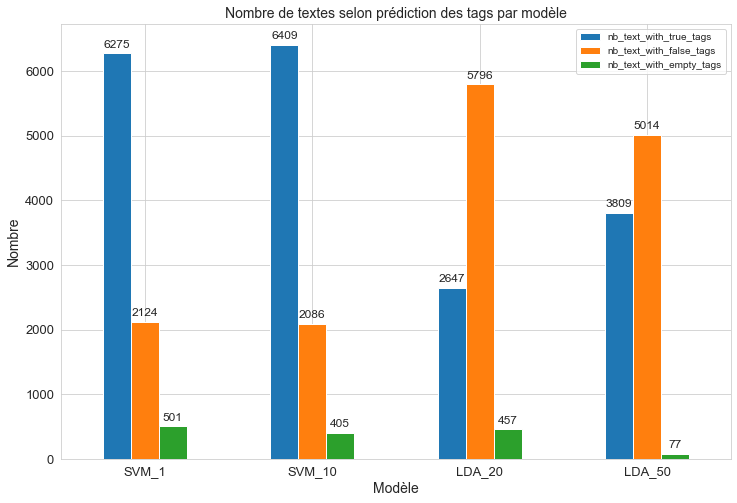

<IPython.core.display.Javascript object>

In [53]:
# Comparaison des résultats via un plot.bar
ax = df_result_tag_type.plot(
    x="modele",
    y=["nb_text_with_true_tags", "nb_text_with_false_tags", "nb_text_with_empty_tags"],
    kind="bar",
    rot=0,
    figsize=(12, 8),
    fontsize=13,
)
plt.ylabel("Nombre", size=14)
plt.xlabel("Modèle", size=14)
# ajout des étiquettes pour afficher valeurs de chaque barre
for p in ax.patches:
    ax.annotate(
        format((p.get_height()), ".0f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 9),
        textcoords="offset points",
        fontsize=12,
    )
plt.legend(loc="upper right")
plt.title("Nombre de textes selon prédiction des tags par modèle", size=14)
plt.show()

Le modèle supervisé a plus de textes avec au moins un tag correctement prédit (70.5% et 72%) vis à vis des tags utilisateurs.

En passant de C = 1 à C = 10 pour le modèle de SVM, on augmente le nombre de textes avec au moins un true_tags, au détriment principalement du nombre de textes sans aucun tag.

Pour le modèle non supervisé, en augmentant le nombre de mots par topic, on passe de 29.7% / 65.1% / 5.2% à 42.8% / 56.3% / 0.9% . On a amélioré ainsi le nombre de textes avec au moins un true_tags, au détriment principalement du nombre de textes sans aucun tag. 

Le modèle LDA avec 50 mots stockés par topic a le nombre de textes sans aucun tag le plus faible.

In [54]:
def display_distrib(df, col):

    """ Fonction pour tracer la distribution d'une colonne d'un dataframe 
    et retourne les informations statistiques de cette colonne
        
    - Arguments :
        - df : dataframe
        - col : colonne du dataframe à représenter
    
    - Affiche :
        - 2 graphes pour la colonne du dataframe df
            - histplot représentant la distribution sous forme d'histogramme
            - boxplot correspondant
        - information statistiques de la colonne     
    """

    # Initialisation de la figure
    f, axes = plt.subplots(2, 1, figsize=(15, 8))
    plt.suptitle("Distribution de {}".format(col), size=14)

    # histogramme
    sns.histplot(x=col, data=df, kde=True, ax=axes[0])
    axes[0].set_ylabel("Nombre d'observations", size=13)
    axes[0].set_xlabel(" ")
    # axes[0].set(xlim=(0, 37))

    # boxplot
    sns.boxplot(x=col, data=df, ax=axes[1])
    axes[1].set_xlabel(col, size=13)
    # axes[1].set(xlim=(0, 37))
    plt.show()

    # Information statistique
    print(df[col].describe())

<IPython.core.display.Javascript object>

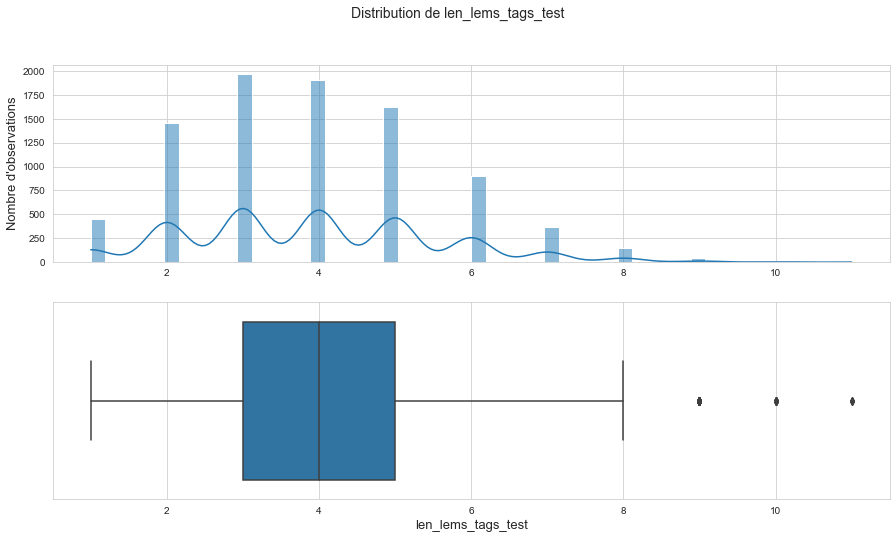

count    8900.000000
mean        3.908876
std         1.658612
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        11.000000
Name: len_lems_tags_test, dtype: float64


<IPython.core.display.Javascript object>

In [55]:
display_distrib(df_comp_label_test, "len_lems_tags_test")

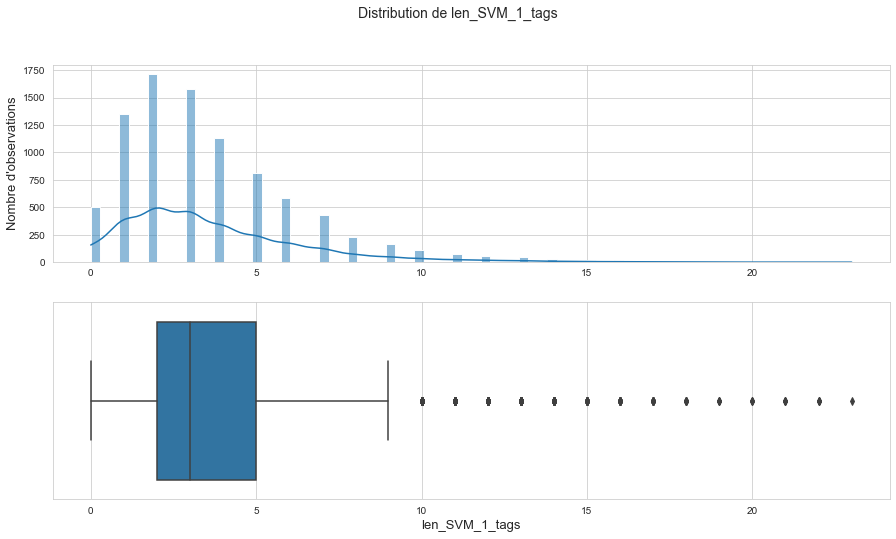

count    8900.000000
mean        3.695281
std         2.877575
min         0.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        23.000000
Name: len_SVM_1_tags, dtype: float64


<IPython.core.display.Javascript object>

In [56]:
display_distrib(df_comp_label_test, "len_SVM_1_tags")

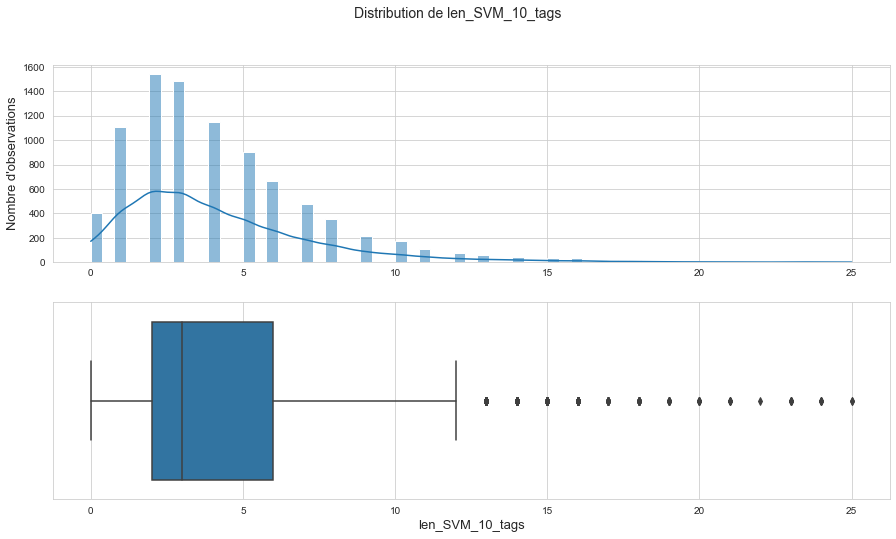

count    8900.000000
mean        4.188652
std         3.204746
min         0.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        25.000000
Name: len_SVM_10_tags, dtype: float64


<IPython.core.display.Javascript object>

In [57]:
display_distrib(df_comp_label_test, "len_SVM_10_tags")

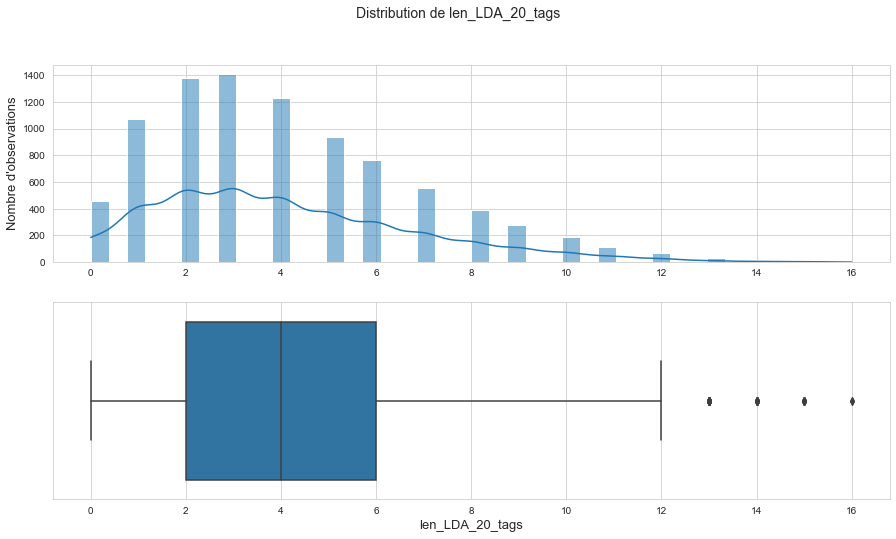

count    8900.000000
mean        4.097416
std         2.765197
min         0.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        16.000000
Name: len_LDA_20_tags, dtype: float64


<IPython.core.display.Javascript object>

In [58]:
display_distrib(df_comp_label_test, "len_LDA_20_tags")

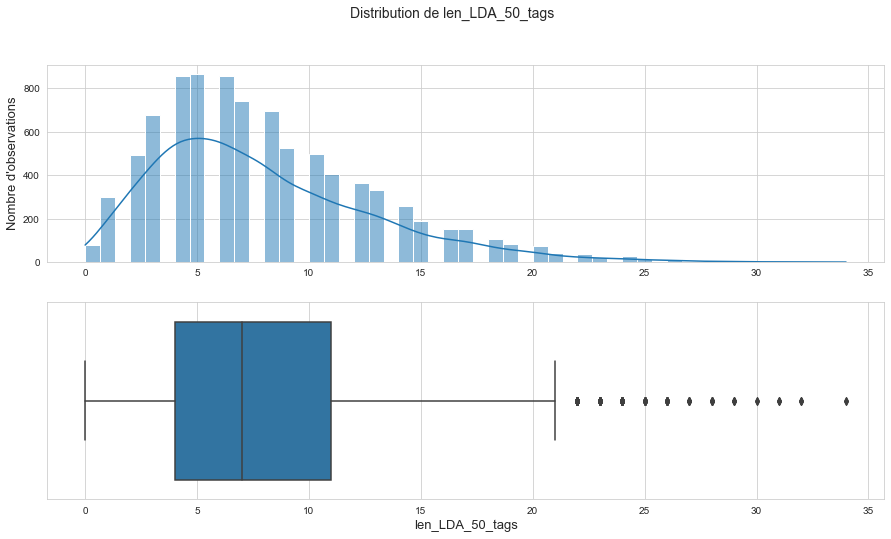

count    8900.000000
mean        7.957640
std         4.983093
min         0.000000
25%         4.000000
50%         7.000000
75%        11.000000
max        34.000000
Name: len_LDA_50_tags, dtype: float64


<IPython.core.display.Javascript object>

In [59]:
display_distrib(df_comp_label_test, "len_LDA_50_tags")

Les prédictions donnent plus de tags que ce que les utilisateurs ont indiqué.

Sans surprise, avec LDA et 50 mots par topic, on a beaucoup plus de tags qui sont prédits et une distribution beaucoup plus étalée.

## Conclusion
Faute de métriques communs, les approches supervisées et non supervisées sont difficilement comparables en terme de performance. On a néanmoins mis en place des comparaisons, notamment vis à vis des tags mis par les utilisateurs.

Même si l'approche non supervisée requiert moins d'étapes (pas de réduction de dimension), elle offre de moins bons résultats : elle prédit beaucoup trop de tags faux. On a donc choisi le modèle de SVM.

Néanmoins, des pistes d'amélioration sont envisageables :
- utilisation d'une librairie autre que sklearn pour le modèle de LDA (librairie Gensim) pour mieux optimiser le nombre de topics
- lors du traitement de texte, utiliser un dictionnaire pertinent des mots précis à garder
    - on a gardé les mots d'au moins 3 lettres, ce qui a éliminé certains langages de programmation
    - ne pas éliminer forcément tous les caractères spéciaux
- pour des raisons de performances de machine, on a limité certains paramètres 
    - on pourrait prendre plus de samples (moins de 50000 ici)
    - on pourrait prendre plus d'autres variables (509 premiers mots gardés, 200 tags gardés)